# Model Evaluation

## Libaries

In [1]:

# Drittanbieter
import time

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from lightgbm import LGBMRegressor
from mlforecast import MLForecast
from mlforecast.feature_engineering import transform_exog
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from utils.dl_helper_functions import (
    load_picture_lagged_data,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from statsforecast import StatsForecast
from statsforecast.models import ARIMA
from tqdm import tqdm
from utils.config import (PRED_COLOR, TRUE_COLOR)

# Eigene Module (utils)
from utils.ml_helper_functions import load_data, load_data_v2
from xgboost import XGBRegressor
DTYPE_NUMPY = np.float32
SEQUENCE_LENGTH = 24  # Anzahl der Schritte in der Sequenz
n_jobs = 16

# Versuch 1

## Load Data

In [2]:
df = load_data()
#df = load_data_v2()


Loading data from:
../data/numerical_data/points30
../data/numerical_data/points10

Loading ocean, weather and insitu data...

Shapes of loaded DataFrames before feature engineering:
Ocean DataFrame: (9415187, 14)
Weather DataFrame: (2018400, 22)
Insitu DataFrame: (20161, 2)

Feature engineering...

Dropping columns: ['snowfall', 'siconc', 'rain', 'sithick', 'precipitation', 'weather_code', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_high', 'cloud_cover_mid', 'vapour_pressure_deficit', 'et0_fao_evapotranspiration', 'relative_humidity_2m', 'temperature_2m', 'dew_point_2m', 'apparent_temperature', 'mlotst']

Shapes of DataFrames after dropping columns:
Ocean DataFrame: (9415187, 11)
Weather DataFrame: (2018400, 8)
Insitu DataFrame: (20161, 2)

Shapes of loaded DataFrames after feature engineering:
Ocean DataFrame: (9415187, 11)
Weather DataFrame: (2018400, 8)
Insitu DataFrame: (20161, 2)

Converting DataFrames to xarray DataArrays...

Running EOF analysis on ocean and weather data...

In [3]:
df

ds  bottomT_PC_1  bottomT_PC_2  bottomT_PC_3  \
0     2022-12-03 00:00:00     -0.303945     -1.571631     -0.796631   
1     2022-12-03 01:00:00     -0.305888     -1.570625     -0.795225   
2     2022-12-03 02:00:00     -0.306904     -1.571336     -0.795739   
3     2022-12-03 03:00:00     -0.308250     -1.573073     -0.795607   
4     2022-12-03 04:00:00     -0.309479     -1.574358     -0.794477   
...                   ...           ...           ...           ...   
20156 2025-03-21 20:00:00     -0.852832      0.304002      0.242566   
20157 2025-03-21 21:00:00     -0.854031      0.301599      0.241763   
20158 2025-03-21 22:00:00     -0.855638      0.299369      0.241838   
20159 2025-03-21 23:00:00     -0.857216      0.297495      0.242355   
20160 2025-03-22 00:00:00     -0.858678      0.295702      0.242991   

       bottomT_PC_4  sla_PC_1  sla_PC_2  sla_PC_3   so_PC_1   so_PC_2  \
0          0.568800 -1.005268 -0.822924  0.530070 -0.218220 -0.897083   
1          0.571684 -1.002811 -0.833910  0.528256 -0.210618 -0.893305   
2          0.570574 -1.006549 -0.904703  0.446098 -0.205510 -0.893562   
3          0.568620 -1.015887 -1.027999  0.293744 -0.205313 -0.898010   
4          0.567034 -1.026219 -1.160469  0.123971 -0.204544 -0.909398   
...             ...       ...       ...       ...       ...       ...   
20156     -0.543267 -0.450593 -1.642004  0.088681 -0.618588 -0.563127   
20157     -0.543499 -0.465324 -1.552174  0.280006 -0.615991 -0.559928   
20158     -0.543754 -0.475831 -1.457704  0.445328 -0.610756 -0.563381   
20159     -0.543240 -0.483009 -1.387714  0.528586 -0.603634 -0.579456   
20160     -0.543012 -0.491368 -1.355000  0.518511 -0.592605 -0.595034   

        so_PC_3   so_PC_4   so_PC_5   so_PC_6   so_PC_7   so_PC_8   so_PC_9  \
0      0.492402 -1.479749  1.945935 -1.708837  0.830561  0.660026  0.225722   
1      0.481362 -1.521018  1.944044 -1.712570  0.832452  0.601833  0.220957   
2      0.476674 -1.559010  1.944211 -1.724287  0.846148  0.536701  0.206006   
3      0.477123 -1.594605  1.938970 -1.735312  0.855395  0.473940  0.159578   
4      0.471819 -1.619637  1.939357 -1.744318  0.862890  0.425579  0.107285   
...         ...       ...       ...       ...       ...       ...       ...   
20156 -0.553653 -0.722979 -0.439382  0.254256  0.237325 -0.709193 -0.154235   
20157 -0.569800 -0.780865 -0.440277  0.195365  0.202590 -0.775384 -0.190465   
20158 -0.559560 -0.799235 -0.497711  0.146846  0.168374 -0.846894 -0.196115   
20159 -0.564451 -0.800986 -0.574245  0.100998  0.129429 -0.916046 -0.167660   
20160 -0.606551 -0.771351 -0.658062  0.056032  0.146795 -0.983629 -0.136037   

       so_PC_10  so_PC_11  so_PC_12  so_PC_13  so_PC_14  so_PC_15  so_PC_16  \
0     -0.037684 -1.047863  0.151338  0.904935  0.266220  1.443508  0.784207   
1     -0.069068 -1.055865  0.110541  0.909764  0.278798  1.370188  0.752076   
2     -0.078033 -1.056282  0.085108  0.891672  0.270216  1.303007  0.736780   
3     -0.082558 -1.079618  0.073794  0.872644  0.246432  1.249117  0.761749   
4     -0.084850 -1.130310  0.053449  0.843531  0.238551  1.199902  0.797326   
...         ...       ...       ...       ...       ...       ...       ...   
20156  0.287599  0.840074  0.050196 -0.157104 -0.409509  0.125976  1.311678   
20157  0.316278  0.826413 -0.065674 -0.137189 -0.298353  0.098626  1.213290   
20158  0.348337  0.814842 -0.119415 -0.139543 -0.293040  0.077014  1.156273   
20159  0.379749  0.864789 -0.155981 -0.166500 -0.294827  0.126284  1.165502   
20160  0.452683  0.862406 -0.202074 -0.132849 -0.409541  0.247640  1.232814   

       so_PC_17  so_PC_18  so_PC_19  so_PC_20  so_PC_21  sob_PC_1  sob_PC_2  \
0      0.407340  1.257197  1.615682  0.082208  0.839712  0.264553  0.254636   
1      0.372693  1.250635  1.550921  0.082548  0.713609  0.259735  0.271430   
2      0.342056  1.274352  1.523114  0.057399  0.650072  0.256050  0.284954   
3      0.329968  1.322249  1.504705 -0.002460  0.665214  0.254308  0.291983   


## Database files

In [4]:
database_files = ['optuna_study_ML_xgboost.db', 'optuna_study_ML_lgbm.db', 'optuna_study_ML_lr.db', 'optuna_study_ML_rf.db', 'optuna_study_ML_svr.db', 'optuna_study_ML_sarima.db']


In [5]:


class EvaluationMLModel:
    def __init__(self, model_type, df, h=24, ocean_points=30, Versuch: str = "1", trial_name: str = "default"):

        self.trial_name = trial_name
        
        self.model_type = model_type
        self.h = h
        self.ocean_points = ocean_points
       
        if self.model_type == 'sarima':
            self.db_name = f'Versuch{Versuch}_optuna_study_ML_sarima.db'
        elif self.model_type == 'xgboost':
            self.db_name = f'Versuch{Versuch}_optuna_study_ML_xgboost.db'
        elif self.model_type == 'lgbm':
            self.db_name = f'Versuch{Versuch}_optuna_study_ML_lgbm.db'
        elif self.model_type == 'random_forest':
            self.db_name = f'Versuch{Versuch}_optuna_study_ML_rf.db'
        elif self.model_type == 'svr':
            self.db_name = f'Versuch{Versuch}_optuna_study_ML_svr.db'
        elif self.model_type == 'lr':
            self.db_name = f'Versuch{Versuch}_optuna_study_ML_lr.db'
        else:
            raise ValueError("Unbekannter Modelltyp. Bitte 'sarima', 'xgboost', 'lgbm', 'random_forest', 'svr' oder 'lr' verwenden.")
        self.n_jobs = n_jobs  # Alle verfügbaren CPU-Kerne nutzen
        self.study = self._open_study_db(self.db_name)
        self.best_params = self._best_params(self.study)
        self.lags = self.best_params.pop('lags')
        self.model = self._model()
        self.df_all = None

        # Transformiere die Exogenen Variablen und entferne die Lags-Spalten
        self.df = transform_exog(df, lags=self.lags, num_threads=-1)     
        cols_to_remove = [col for col in self.df.columns if col.startswith('y_lag')]
        self.df = self.df.drop(columns=set(cols_to_remove))

        

        self.df_train = self.df.loc[self.df['ds'] < '2025-03-01']
        self.df_temp = self.df.loc[self.df['ds'] >= '2025-03-01']
        self.df_val = self.df_temp.iloc[:-self.h]
        self.df_test = self.df_temp.iloc[-self.h:]

        # 
        if self.model_type == "sarima":
            # Use just the columns ['ds', 'unique_id', 'y'] for SARIMA
            self.df_train = self.df_train[["ds", "unique_id", "y"]]
            self.df_temp = self.df_temp[["ds", "unique_id", "y"]]
            self.df_val = self.df_val[["ds", "unique_id", "y"]]
            self.df_test = self.df_test[["ds", "unique_id", "y"]]

        self.random_state = 42  # Für Reproduzierbarkeit
        

        # Parametriere die Cross-Validation-Window-Logik
        self.len_df = len(self.df)
        self.initial_train_window = 24 * 30 * 6   # 6 Monate
        self.step_size = 24                   # 7 Tage
        self.horizon = 24                    # 7 Tage
        self.n_windows = ((self.len_df - self.initial_train_window) // self.horizon) + 200
        self._print_model_info()

    def _print_model_info(self):
        display(self.df.head())
        print(self.df.columns.to_list())
        print(self.df.info())
        print(f"Modelltyp: {self.model_type}")
        print(f"Optimierungsstudie: {self.db_name}")
        print(f"Beste Parameter: {self.best_params}")
        print(f"Lags: {self.lags}")
        print(f"Trainingsdaten: {len(self.df_train)} Zeilen")
        print(f"Validierungsdaten: {len(self.df_val)} Zeilen")
        print(f"Testdaten: {len(self.df_test)} Zeilen")
        print(f"Anzahl der Trainingsfenster: {self.n_windows}")
        print(f"Study Name: {self.study.study_name}")
        
        if isinstance(self.model, StatsForecast):
            first_model = self.model.models[0]
            print(f"StatsForecast Modell: {first_model.__class__.__name__} mit Order {first_model.order} und Seasonal Order {first_model.seasonal_order}")
            self.model_name = first_model.__class__.__name__

        elif isinstance(self.model, MLForecast):
            first_model = list(self.model.models.values())[0]
            print(f"MLForecast Modell: {first_model.steps[-1][1].__class__.__name__} mit Lags {self.lags}")
            self.model_name = first_model.steps[-1][1].__class__.__name__
            
        else:
            print(f"MLForecast Modell: {self.model.models[0].named_steps['model'].__class__.__name__} mit Lags {self.lags}")
        

    def _open_study_db(self, db_name):
        storage = f'sqlite:///{db_name}'
        study_name_list = optuna.study.get_all_study_names(storage=storage)
        print(study_name_list)

        study_name = next((name for name in study_name_list
                           if f'points{self.ocean_points}' in name and f'h{self.h}' in name), None)

        if study_name is None:
            raise ValueError(
                f"Keine passende Studie gefunden für points{self.ocean_points} und h{self.h} in {db_name}.\n"
                f"Verfügbare Studien: {study_name_list}"
            )
        return optuna.load_study(study_name=study_name, storage=storage)

    def _best_params(self, study):
        return study.best_trial.params

    def visualize_study(self):
        import optuna.visualization as vis
        vis.plot_optimization_history(self.study).show()
        vis.plot_param_importances(self.study).show()
        vis.plot_parallel_coordinate(
            self.study,
            params=[p for p, v in self.best_params.items() if isinstance(v, (int, float, str))]
        ).show()

    def _model(self):
        params = self.best_params.copy()

        if self.model_type == "sarima":
            # Use just the columns ['ds', 'unique_id', 'y'] for SARIMA
            
            return StatsForecast(
                models=[ARIMA(
                    order=(params["p"], params["d"], params["q"]),
                    seasonal_order=(params["P"], params["D"], params["Q"]),
                    season_length=params["s"]
                )],
                freq="h",
                n_jobs=self.n_jobs,
            )

        

        if self.model_type == "xgboost":
            model = XGBRegressor(**params, verbosity=0)
        elif self.model_type == "lgbm":
            model = LGBMRegressor(**params, verbosity=-1)
        elif self.model_type == "random_forest":
            model = RandomForestRegressor(**params)
        elif self.model_type == "svr":
            model = SVR(**params)
        elif self.model_type == "lr":
            degree = params.pop("degree")
            interaction_only = params.pop("interaction_only")
            include_bias = params.pop("include_bias")
            positive = params.pop("positive", False)
            poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=include_bias)
            model = Pipeline([
                #("poly", poly),
                ("scaler", StandardScaler()),
                ("model", LinearRegression(n_jobs=self.n_jobs)) #self.n_jobs 
            ])
            return MLForecast(models=[model], freq="h", lags=self.lags)
        else:
            raise ValueError("Unbekannter Modelltyp.")

        pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])

        return MLForecast(models=[pipe], freq="h", lags=self.lags)

    # def fit(self, df=None):
    #     if isinstance(self.model, StatsForecast):
    #         self.model.fit(df=df)
    #     elif isinstance(self.model, MLForecast):
    #         self.model.fit(df=df, keep_last_n=self.h, static_features=[])
    #     elif df is None:
    #         raise ValueError("Für StatsForecast und MLForecast muss ein DataFrame übergeben werden.")
    #     else:
    #         raise ValueError("Unbekannter Modelltyp.")

    def create_forecast_df(self):
        

        all_forecasts = []
        for i in tqdm(range(0, len(self.df_val), self.h), desc="Rolling Window Progress"):
            if len(self.df_val) - i < self.h:
                continue

            history = pd.concat([self.df_train, self.df_val.iloc[:i]])

            if isinstance(self.model, StatsForecast):
                history = history[["ds", "unique_id", "y"]]
                self.model.fit(history)
                #exog_cols = [c for c in self.df_val.columns if c not in ["unique_id", "ds", "y"]]
                #X_exog = self.df_val.iloc[i:i + self.h][["unique_id", "ds"] + exog_cols]
                preds = self.model.predict(h=self.h)
                
            elif isinstance(self.model, MLForecast):
                self.model.fit(history, static_features=[])
                base_future = self.model.make_future_dataframe(h=self.h)
                exog_cols = [c for c in self.df_val.columns if c not in ["unique_id", "ds", "y"]]
                exog_future = self.df_val[["unique_id", "ds"] + exog_cols]
                future_df = base_future.merge(exog_future, on=["unique_id", "ds"], how="left").fillna(0) # dropna statt fillna(0) ?
                preds = self.model.predict(h=self.h, new_df=history, X_df=future_df)
            else:
                raise ValueError("Unbekannter Modelltyp.")

            fc_col = [c for c in preds.columns if c not in ["unique_id", "ds"]][0]
            preds = preds.rename(columns={fc_col: "forecast"})
            mask = (self.df_val["ds"] >= preds["ds"].min()) & (self.df_val["ds"] <= preds["ds"].max())
            true_block = self.df_val.loc[mask, ["unique_id", "ds", "y"]]
            merged = true_block.merge(preds[["unique_id", "ds", "forecast"]], on=["unique_id", "ds"])
            all_forecasts.append(merged)

        self.df_all = pd.concat(all_forecasts).sort_values("ds")
        return self.df_all




    def cross_validation_results(self):
        """
        Führt eine Cross-Validation mit Zeitmessung durch und gibt die Ergebnisse zurück.
        Für MLForecast und StatsForecast werden Fit- und Predict-Zeiten pro Fenster mitgeloggt.
        """
        

        df_cross = self.df_train
        df_cross = pd.concat([df_cross, self.df_val], ignore_index=True).dropna()

        if isinstance(self.model, StatsForecast):
            # Use just the columns ['ds', 'unique_id', 'y'] for SARIMA
            df_cross = df_cross[["ds", "unique_id", "y"]]
            all_results = []
            display(df_cross)
            for i in tqdm(range(self.n_windows), desc="StatsForecast CV mit Zeitmessung"):
                start_idx = i * self.step_size
                train_df = df_cross.iloc[:start_idx + self.horizon]
                test_df = df_cross.iloc[start_idx + self.horizon:start_idx + 2 * self.horizon]

                if len(test_df) < self.horizon:
                    continue

            

                t0 = time.time()
                self.model.fit(df=train_df)
                fit_time = time.time() - t0

                t1 = time.time()
                preds = self.model.predict(h=self.horizon, 
                                           #X_df=test_df.drop(columns=["y"])
                                           )
                predict_time = time.time() - t1

                preds["fit_time"] = fit_time
                preds["predict_time"] = predict_time
                preds["cutoff"] = df_cross["ds"].iloc[start_idx + self.horizon - 1]

                merged = test_df[["unique_id", "ds", "y"]].merge(preds, on=["unique_id", "ds"], how="left")
                # for col in ["fit_time", "predict_time", "cutoff"]:
                #     merged[col] = preds[col].iloc[0]

                all_results.append(merged)

            results = pd.concat(all_results).sort_values("ds").reset_index(drop=True)
            

            return results

        elif isinstance(self.model, MLForecast):
            all_results = []
            for i in tqdm(range(self.n_windows), desc="MLForecast CV mit Zeitmessung"):
                start_idx = i * self.step_size
                train = df_cross.iloc[:start_idx + self.horizon]
                test = df_cross.iloc[start_idx + self.horizon:start_idx + 2 * self.horizon]

                if len(test) < self.horizon:
                    continue

                t0 = time.time()
                self.model.fit(train, static_features=[])
                fit_time = time.time() - t0

                base_future = self.model.make_future_dataframe(h=self.horizon)
                exog_cols = [c for c in df_cross.columns if c not in ["unique_id", "ds", "y"]]
                X_df = test[["unique_id", "ds"] + exog_cols] if exog_cols else None

                t1 = time.time()
                preds = self.model.predict(
                    h=self.horizon,
                    new_df=train,
                    X_df=X_df
                )
                predict_time = time.time() - t1

                preds["fit_time"] = fit_time
                preds["predict_time"] = predict_time
                preds["cutoff"] = df_cross["ds"].iloc[start_idx + self.horizon - 1]

                # Merge mit Ground Truth (y)
                merged = test[["unique_id", "ds", "y"]].merge(preds, on=["unique_id", "ds"], how="left")
                all_results.append(merged)

            results = pd.concat(all_results).sort_values("ds").reset_index(drop=True)
            return results

        else:
            raise NotImplementedError("Unbekannter Modelltyp für Cross-Validation.")
        


    def get_model_statistics(self, results_df=None):

        """
        Gibt ein DataFrame mit den wichtigsten Modellstatistiken zurück.
        """
        if results_df is None or results_df.empty:
            #results_df = self.cross_validation_results()
            print("Warnung: Keine Ergebnisse für die Modellstatistik. Cross-Validation wird durchgeführt.")


        forecast_col = [c for c in results_df.columns if c not in ["unique_id", "ds", 'y', 'cutoff', 'fit_time', 'predict_time']][0]

        bins=[1, 1.25, 1.5, 2.0]

        y_true = results_df["y"].values
        y_pred = results_df[forecast_col].values

        y_true_class = np.digitize(y_true, bins)
        y_pred_class = np.digitize(y_pred, bins)

        # Fehlermaße
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        
        # Korrelation
        try:
            r_value, _ = pearsonr(y_true, y_pred)
            r_squared = r2_score(y_true, y_pred)
        except:
            r_value = np.nan



        recall = recall_score(y_true_class, y_pred_class, average="macro")
        precision = precision_score(y_true_class, y_pred_class, average="macro")
        accuracy = accuracy_score(y_true_class, y_pred_class)
        f1 = f1_score(y_true_class, y_pred_class, average="macro")

        # Laufzeit-Mittelwerte (falls vorhanden)
        if 'fit_time' in results_df.columns and 'predict_time' in results_df.columns:
            avg_fit_time = results_df['fit_time'].mean()
            avg_predict_time = results_df['predict_time'].mean()
        else:
            avg_fit_time = np.nan
            avg_predict_time = np.nan

        # Anzahl Parameter
        num_params = len(self.best_params) if self.best_params is not None else np.nan
        model_name = [c for c in results_df.columns if c not in ["unique_id", "ds", 'y', 'cutoff', 'fit_time', 'predict_time']][0]
            
        # Zusammenfassung
        stats = {
            'Model': model_name,
            "MSE": round(mse, 3),
            "RMSE": round(rmse, 3),
            "MAE": round(mae, 3),
            #"R": round(r_value, 3),
            #"R²": round(r_squared, 3),
            "Recall": round(recall, 3),
            "Precision": round(precision, 3),
            "Accuracy": round(accuracy, 3),
            "F1-Score": round(f1, 3),
            "Avg. Fit Time (s)": round(avg_fit_time, 3),
            "Avg. Predict Time (s)": round(avg_predict_time, 3),
            "Num Params": num_params
        }

        return pd.DataFrame([stats])
        
    def plot_cross_validation_results(self, results=None, start_date=None, end_date=None, title="Forecast vs. Actual Water Level"):
        
        if results is None or results.empty:
            results = self.cross_validation_results()

        if start_date is not None:
            results = results[results['ds'] >= start_date]
        if end_date is not None:
            results = results[results['ds'] <= end_date]

        # Entferne unendliche Werte und ersetze durch NaN, dann drop
        results = results.replace([np.inf, -np.inf], np.nan)
        forecast_col = [c for c in results.columns if c not in ['unique_id', 'ds', 'cutoff', 'y']][0]
        # Nur Zeilen behalten, die sowohl y als auch Forecast finite haben
        valid_mask = results['y'].notna() & results[forecast_col].notna()
        if not valid_mask.any():
            print("Warnung: Nach dem Filtern sind keine gültigen y-/Forecast-Werte vorhanden. Plot wird übersprungen.")
            return
        results = results.loc[valid_mask].copy()

        # Jetzt erst plotten
        flood_levels = [
            (1.0, 1.25, 'yellow', 'storm surge'),
            (1.25, 1.5, 'orange', 'medium storm surge'),
            (1.5, 2.0, 'red', 'heavy storm surge'),
            (2.0, 3.5, 'darkred', 'very heavy storm surge'),
        ]

        fig, ax = plt.subplots(figsize=(12, 8))

        ax.plot(results['ds'], results[forecast_col], label='Forecasts', alpha=0.7, color=PRED_COLOR)
        ax.plot(results['ds'], results['y'], label='True Values', alpha=0.7, color=TRUE_COLOR)

        ax.fill_between(results['ds'], results['y'], results[forecast_col],
                        color='grey', alpha=0.3)

        for y0, y1, color, label in flood_levels:
            ax.axhspan(y0, y1, facecolor=color, alpha=0.2, label=label)

        for i in range(0, len(results), self.horizon):
            label = 'begin new forecast' if i == 0 else None
            ax.axvline(x=results['ds'].iloc[i], color='grey', linestyle='--', linewidth=1.5, label=label, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

        # sichere y-Limits berechnen (min/max über y und forecast)
        y_min = min(results['y'].min(), results[forecast_col].min())
        y_max = max(results['y'].max(), results[forecast_col].max())
        ax.set_ylim(y_min - 0.5, y_max + 0.5)

        ax.set_xlabel("Time")
        ax.set_ylabel("Water Level [m]")

        ax.set_title(title)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)
        ax.yaxis.set_major_locator(plt.MaxNLocator(10))
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
        fig.autofmt_xdate()
        ax.grid(True)
        plt.tight_layout()
        if start_date or end_date is None:
            start_date = results['ds'].min().strftime("%Y-%m-%d")
            end_date = results['ds'].max().strftime("%Y-%m-%d")
        plt.savefig(f"../thesis_plots/{self.trial_name}_ML_cross_validation_{self.model_name}_h{self.h}_startdate{start_date}_enddate{end_date}.png", dpi=300)
        plt.show()



    def plot_test_forecast(self):
        
        
        df_train_val = pd.concat([self.df_train, self.df_val])
        
        

        if isinstance(self.model, StatsForecast):
            df_train_val.dropna(inplace=True)
            future_df = self.df_test.drop(columns=["y"])
            self.model.fit(df=df_train_val)
            preds = self.model.predict(h=self.h, X_df=future_df)
            fc_col = [c for c in preds.columns if c not in ["unique_id", "ds"]][0] # get model column e.g. SARIMA
            preds = preds.rename(columns={fc_col: "forecast"})
            results = self.df_test[["unique_id", "ds", "y"]].merge(preds, on=["unique_id", "ds"], how="left")

        elif isinstance(self.model, MLForecast):
            self.model.fit(df=df_train_val, static_features=[])
            base_future = self.model.make_future_dataframe(h=self.h)
            future_df = base_future.merge(self.df_test, on=["unique_id", "ds"], how="left").fillna(0)
            preds = self.model.predict(h=self.h, new_df=df_train_val, X_df=future_df)
            fc_col = [c for c in preds.columns if c not in ["unique_id", "ds"]][0] # get model column e.g. LinearRegression
            preds = preds.rename(columns={fc_col: "forecast"})
            results = self.df_test[["unique_id", "ds", "y"]].merge(preds, on=["unique_id", "ds"], how="left")

        # --- Fehlerabfang: Keine Daten oder nur NaN ---
        if results.empty or results['y'].dropna().empty or results['forecast'].dropna().empty:
            print("Warnung: Keine gültigen Werte für y oder forecast im Test-DataFrame. Plot wird übersprungen.")
            return
           
        # Highlight storm surge classes with colored bands
        flood_levels = [
            (1.0, 1.25, 'yellow', 'storm surge'),
            (1.25, 1.5, 'orange', 'medium storm surge'),
            (1.5, 2.0, 'red', 'heavy storm surge'),
            (2.0, 3.5, 'darkred', 'very heavy storm surge'),
        ]

        fig, ax = plt.subplots(figsize=(12, 8))

        ax.plot(results['ds'], results['forecast'], label='Forecast', alpha=0.7, color=PRED_COLOR)
        ax.plot(results['ds'], results['y'], label='True Values', color=TRUE_COLOR, alpha=0.7)
        ax.fill_between(results["ds"], results["y"], results["forecast"],
                         color='lightgrey', alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

        for y0, y1, color, label in flood_levels:
            ax.axhspan(y0, y1, facecolor=color, alpha=0.2, label=label)

        for i in range(0, len(results), self.h):
            label = 'begin new forecast' if i == 0 else None
            ax.axvline(x=results["ds"].iloc[i], color='gray', linestyle='--', linewidth=1.5, label=label)

        ax.set_xlabel("Time")
        ax.set_ylabel("Water Level [m]")
        ax.set_title("Forecast vs. Actual Water Level")
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)
        ax.set_ylim(results['y'].min() - 0.5, results['y'].max() + 0.5)
        ax.yaxis.set_major_locator(plt.MaxNLocator(10)) # make y-axis labels readable
        ax.xaxis.set_major_locator(plt.MaxNLocator(10)) # make x-axis labels readable
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
        fig.autofmt_xdate()
        ax.grid(True)
        plt.tight_layout()
        plt.savefig(f"../thesis_plots/{self.trial_name}_ML_test_forecast_{self.model_name}_h{self.h}.png", dpi=300)
        plt.show()


    def plot_rmse_per_cutoff(self, results=None):

        """
        Plottet den RMSE pro Cross-Validation-Fenster mit Mittelwert, Standardabweichung
        und Markierung von Sturmflut-Fenstern (y > 1.0).
        """
        if results is None or results.empty:
            results = self.cross_validation_results()

        forecast_col = [c for c in results.columns if c not in ['unique_id', 'ds', 'cutoff', 'y']][0]

        # RMSE pro Fenster berechnen
        grouped = results.groupby('cutoff')
        errors = grouped.apply(lambda x: mean_squared_error(x['y'], x[forecast_col]))

        mean_rmse = errors.mean()
        std_rmse = errors.std()

        # Identifiziere Sturmflut-Fenster (mind. 1 y > 1.0)
        sturmflut_cutoffs = grouped.filter(lambda x: (x['y'] >= 1.0).any())['cutoff'].unique()

        # Plot vorbereiten
        fig, ax = plt.subplots(figsize=(12, 5))
        errors.plot(marker='o', label='RMSE for each window', color='blue', ax=ax)

        ax.axhline(y=mean_rmse, color='green', linestyle='--', label=f'Ø RMSE = {mean_rmse:.3f}')
        ax.fill_between(errors.index, mean_rmse - std_rmse, mean_rmse + std_rmse,
                        color='green', alpha=0.2, label=f'±1 Std = {std_rmse:.3f}')

        # Farbig markieren: Sturmflut-Fenster
        for cutoff in sturmflut_cutoffs:
            if cutoff in errors.index:
                label = 'storm surge window' if cutoff == sturmflut_cutoffs[0] else None
                ax.axvspan(cutoff, cutoff + pd.Timedelta(hours=self.h), color='red', alpha=0.15, label=label)
                #plt.axvspan(cutoff, cutoff, color='red', alpha=0.15, linewidth=10)

        ax.set_title("RMSE per Cross-Validation Window")
        ax.set_ylabel("RMSE")
        ax.set_xlabel("Cutoff Time")
        ax.yaxis.set_major_locator(plt.MaxNLocator(10)) # make y-axis labels readable
        ax.xaxis.set_major_locator(plt.MaxNLocator(10)) # make x-axis labels readable
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
        fig.autofmt_xdate()
        ax.grid(True)
        plt.tight_layout()
        plt.savefig(f"../thesis_plots/{self.trial_name}_ML_rmse_per_cutoff_{self.model_name}_h{self.h}.png", dpi=300)
        plt.show()

        
    def plot_multiclass_recall_per_cutoff(self, results_df=None):

        """
        Plottet den macro-Recall pro Cross-Validation-Fenster mit mehrklassiger Klassifikation.
        
        Bins definieren die Klassengrenzen.
        """
        if results_df is None or results_df.empty:
            results_df = self.cross_validation_results()
            
        recall_per_cutoff = []
        grouped = results_df.groupby("cutoff")
        bins=[1, 1.25, 1.5, 2.0]
        forecast_col = [c for c in results_df.columns if c not in ['unique_id', 'ds', 'cutoff', 'y']][0]

        for cutoff, group in grouped:
            y_true = group["y"].values
            y_pred = group[forecast_col].values

            y_true_class = np.digitize(y_true, bins)
            y_pred_class = np.digitize(y_pred, bins)

            # Falls eine Klasse im y_true fehlt, wird Recall mit NaN vermieden durch try-except
            try:
                recall = recall_score(y_true_class, y_pred_class, average="macro", zero_division=0)
            except ValueError:
                recall = np.nan  # wenn keine Klassen vorhanden

            recall_per_cutoff.append((cutoff, recall))

        # In DataFrame umwandeln
        recall_df = pd.DataFrame(recall_per_cutoff, columns=["cutoff", "recall"])

        # Calculating average recall over all data
        y_true_all = results_df["y"].values
        y_pred_all = results_df[forecast_col].values
        y_true_class_all = np.digitize(y_true_all, bins)
        y_pred_class_all = np.digitize(y_pred_all, bins)
        recall = recall_score(y_true_class_all, y_pred_class_all, average="macro")

        # Plot
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.plot(recall_df["cutoff"], recall_df["recall"], marker="o", color="blue", label="Recall")
        ax.axhline(y=recall, color='gray', linestyle='--', label='Recall {:.3f}'.format(recall))

        # Farbig markieren: Sturmflut-Fenster
        sturmflut_cutoffs = results_df[results_df["y"] >= 1.0]["cutoff"].unique()
        for cutoff in sturmflut_cutoffs:
            if cutoff in recall_df["cutoff"].values:
                label = 'storm surge window' if cutoff == sturmflut_cutoffs[0] else None
                ax.axvspan(cutoff, cutoff + pd.Timedelta(hours=self.h), color='red', alpha=0.15, label=label)

        ax.set_title("Recall per window ")
        ax.set_xlabel("Cutoff")
        ax.set_ylabel("Recall (macro)")
        ax.set_ylim(0, 1.05)
        ax.yaxis.set_major_locator(plt.MaxNLocator(10)) # make y-axis labels readable
        ax.xaxis.set_major_locator(plt.MaxNLocator(10)) # make x-axis labels readable
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
        fig.autofmt_xdate()
        ax.grid(True)
        plt.tight_layout()
        plt.savefig(f"../thesis_plots/{self.trial_name}_ML_multiclass_recall_per_cutoff_{self.model_name}_h{self.h}.png", dpi=300)
        plt.show()

    def get_coefficients(self):
        if not isinstance(self.model, MLForecast):
            return None
            #raise ValueError("Nur für MLForecast-Modelle verfügbar.")
        
        

        pipe = self.model.models_[self.model_name]

        reg = pipe.named_steps['model']

        # Feature-Namen bestimmen
        try:
            poly = pipe.named_steps['poly']
            feature_names = poly.get_feature_names_out(self.model.ts.features_order_)
        except Exception:
            feature_names = getattr(self.model.ts, "features_order_", None)
            if feature_names is None:
                feature_names = [f"x{i}" for i in range(reg.n_features_in_)] if hasattr(reg, "n_features_in_") else []

        # Lineare Modelle
        if hasattr(reg, 'coef_'):
            return pd.DataFrame({
                'feature': feature_names,
                'coefficient': reg.coef_
            })

        # Baumbasierte Modelle: Feature Importances
        elif hasattr(reg, 'feature_importances_'):
            return pd.DataFrame({
                'feature': feature_names,
                'importance': reg.feature_importances_
            }).sort_values('importance', ascending=False)

        # XGBoost: Booster Feature Importances (falls vorhanden)
        elif hasattr(reg, 'get_booster'):
            booster = reg.get_booster()
            fmap = booster.get_score(importance_type='weight')
            importances = [fmap.get(f'f{i}', 0) for i in range(len(feature_names))]
            return pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

        # SVR mit linearem Kernel
        elif hasattr(reg, 'coef_'):
            return pd.DataFrame({
                'feature': feature_names,
                'coefficient': reg.coef_.ravel()
            })

        else:
            raise ValueError("Dieses Modell unterstützt keine Feature-Koeffizienten oder Importances.")

    def plot_coefficients(self, coeff_df=None):
        """
        Plottet die Koeffizienten oder Feature-Importances des Modells.
        """

        if not isinstance(self.model, MLForecast):
            print("Nur für MLForecast-Modelle verfügbar.")
            return None
        
        if coeff_df is None:
            try:
                coeff_df = self.get_coefficients()
            except ValueError as e:
                print(str(e))
                return None

        if coeff_df.empty or coeff_df is None:
            print("Keine Koeffizienten oder Importances verfügbar.")
            return None

        n = 20
        # Plot n-largest coefficients or importances
        # Bestimme, welche Spalte verwendet werden soll
        value_col = 'coefficient' if 'coefficient' in coeff_df.columns else 'importance'

        # Plot n-largest
        fig, ax = plt.subplots(figsize=(12, len(coeff_df.nlargest(n, value_col)) * 0.3))
        coeff_df.nlargest(n, value_col).plot.barh(x='feature', y=value_col, ax=ax)
        ax.set_xlabel("Coefficient" if value_col == 'coefficient' else "Feature Importance")
        ax.set_ylabel("Feature")
        ax.set_title(f"Largest Coefficients/Importances for {self.model_name}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"../thesis_plots/{self.trial_name}_ML_coefficients_{self.model_name}_h{self.h}_largest.png", dpi=300)
        plt.show()

        plt.clf()
        plt.close(fig)

        # Plot n-smallest
        fig, ax = plt.subplots(figsize=(12, len(coeff_df.nsmallest(n, value_col)) * 0.3))
        coeff_df.nsmallest(n, value_col).plot.barh(x='feature', y=value_col, ax=ax)
        ax.set_xlabel("Coefficient" if value_col == 'coefficient' else "Feature Importance")
        ax.set_ylabel("Feature")
        ax.set_title(f"Smallest Coefficients/Importances for {self.model_name}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"../thesis_plots/{self.trial_name}_ML_coefficients_{self.model_name}_h{self.h}_smallest.png", dpi=300)
        plt.show()

    
    

        


## Linear Regression

In [6]:
folds = {
    "Surge1": pd.Timestamp("2023-02-25 16:00:00"),
    "Surge2": pd.Timestamp("2023-04-01 09:00:00"),
    "Surge3": pd.Timestamp("2023-10-07 20:00:00"),
    "Surge4": pd.Timestamp("2023-10-20 21:00:00"),
    "Surge5": pd.Timestamp("2024-01-03 01:00:00"),
    "Surge6": pd.Timestamp("2024-02-09 15:00:00"),
    "Surge7": pd.Timestamp("2024-12-09 10:00:00"),
    "normal1": pd.Timestamp("2023-07-01 14:00:00"),
    "normal2": pd.Timestamp("2024-04-01 18:00:00"),
    "normal3": pd.Timestamp("2025-01-01 12:00:00"),
}
    

gap = pd.Timedelta(hours=168)


model_stats_all = pd.DataFrame()

['LR_points30_h168_ml_test', 'LR_points30_h24_ml_test']


ds  bottomT_PC_1  bottomT_PC_2  bottomT_PC_3  bottomT_PC_4  \
0 2022-12-03 00:00:00     -0.303945     -1.571631     -0.796631      0.568800   
1 2022-12-03 01:00:00     -0.305888     -1.570625     -0.795225      0.571684   
2 2022-12-03 02:00:00     -0.306904     -1.571336     -0.795739      0.570574   
3 2022-12-03 03:00:00     -0.308250     -1.573073     -0.795607      0.568620   
4 2022-12-03 04:00:00     -0.309479     -1.574358     -0.794477      0.567034   

   sla_PC_1  sla_PC_2  sla_PC_3   so_PC_1   so_PC_2   so_PC_3   so_PC_4  \
0 -1.005268 -0.822924  0.530070 -0.218220 -0.897083  0.492402 -1.479749   
1 -1.002811 -0.833910  0.528256 -0.210618 -0.893305  0.481362 -1.521018   
2 -1.006549 -0.904703  0.446098 -0.205510 -0.893562  0.476674 -1.559010   
3 -1.015887 -1.027999  0.293744 -0.205313 -0.898010  0.477123 -1.594605   
4 -1.026219 -1.160469  0.123971 -0.204544 -0.909398  0.471819 -1.619637   

    so_PC_5   so_PC_6   so_PC_7   so_PC_8   so_PC_9  so_PC_10  so_PC_11  \
0  1.945935 -1.708837  0.830561  0.660026  0.225722 -0.037684 -1.047863   
1  1.944044 -1.712570  0.832452  0.601833  0.220957 -0.069068 -1.055865   
2  1.944211 -1.724287  0.846148  0.536701  0.206006 -0.078033 -1.056282   
3  1.938970 -1.735312  0.855395  0.473940  0.159578 -0.082558 -1.079618   
4  1.939357 -1.744318  0.862890  0.425579  0.107285 -0.084850 -1.130310   

   so_PC_12  so_PC_13  so_PC_14  so_PC_15  so_PC_16  so_PC_17  so_PC_18  \
0  0.151338  0.904935  0.266220  1.443508  0.784207  0.407340  1.257197   
1  0.110541  0.909764  0.278798  1.370188  0.752076  0.372693  1.250635   
2  0.085108  0.891672  0.270216  1.303007  0.736780  0.342056  1.274352   
3  0.073794  0.872644  0.246432  1.249117  0.761749  0.329968  1.322249   
4  0.053449  0.843531  0.238551  1.199902  0.797326  0.316378  1.390427   

   so_PC_19  so_PC_20  so_PC_21  sob_PC_1  sob_PC_2  sob_PC_3  sob_PC_4  \
0  1.615682  0.082208  0.839712  0.264553  0.254636 -1.669036  0.791188   
1  1.550921  0.082548  0.713609  0.259735  0.271430 -1.669632  0.789600   
2  1.523114  0.057399  0.650072  0.256050  0.284954 -1.667553  0.789894   
3  1.504705 -0.002460  0.665214  0.254308  0.291983 -1.664166  0.784284   
4  1.485329 -0.068221  0.715472  0.254585  0.297858 -1.660127  0.783129   

   sob_PC_5  sob_PC_6  sob_PC_7  sob_PC_8  sob_PC_9  sob_PC_10  sob_PC_11  \
0 -0.179636  0.022623  0.643463 -0.607757 -2.275575  -0.271110   2.232440   
1 -0.226949  0.082152  0.661515 -0.607035 -2.254747  -0.248653   2.227916   
2 -0.262441  0.130412  0.681979 -0.602594 -2.231523  -0.236153   2.221946   
3 -0.283047  0.170041  0.700163 -0.598078 -2.207416  -0.228100   2.214447   
4 -0.294301  0.188554  0.711769 -0.597417 -2.183183  -0.213062   2.206021   

   sob_PC_12  sob_PC_13  sob_PC_14  sob_PC_15  sob_PC_16  sob_PC_17  \
0   2.175432   1.667905  -1.114560   1.036917  -0.649352   0.085947   
1   2.186811   1.623602  -1.106727   0.991440  -0.647355   0.070829   
2   2.199752   1.607716  -1.141528   0.905202  -0.641713   0.067386   
3   2.208812   1.611233  -1.192685   0.813053  -0.635158   0.079425   
4   2.224724   1.645976  -1.264315   0.699793  -0.643793   0.105970   

   sob_PC_18  sob_PC_19  sob_PC_20  sob_PC_21  sob_PC_22  sob_PC_23  \
0   0.039516   0.149573   1.011663   0.578998  -1.767117  -0.969698   
1  -0.006989   0.095796   0.979036   0.573021  -1.714309  -1.045219   
2  -0.032400   0.034161   0.940107   0.564657  -1.674537  -1.113952   
3  -0.049929  -0.010915   0.888790   0.546142  -1.653721  -1.153607   
4  -0.057998  -0.042699   0.830250   0.521896  -1.639177  -1.151354   

   sob_PC_24  sob_PC_25  sob_PC_26  thetao_PC_1   uo_PC_1   vo_PC_1   wo_PC_1  \
0   2.975066  -0.136664   0.596100    -0.332200 -1.676010 -0.916467 -0.988585   
1   3.015842  -0.200679   0.572013    -0.337065 -1.672298 -0.883804 -0.892139   
2   3.037881  -0.231346   0.522573    -0.338199 -1.682788 -0.840234 -0.873372   
3   3.020837  -0.239250   0.468367    -0.339460 -1.682179 -0.816337 -0.875945   
4   2.

['ds', 'bottomT_PC_1', 'bottomT_PC_2', 'bottomT_PC_3', 'bottomT_PC_4', 'sla_PC_1', 'sla_PC_2', 'sla_PC_3', 'so_PC_1', 'so_PC_2', 'so_PC_3', 'so_PC_4', 'so_PC_5', 'so_PC_6', 'so_PC_7', 'so_PC_8', 'so_PC_9', 'so_PC_10', 'so_PC_11', 'so_PC_12', 'so_PC_13', 'so_PC_14', 'so_PC_15', 'so_PC_16', 'so_PC_17', 'so_PC_18', 'so_PC_19', 'so_PC_20', 'so_PC_21', 'sob_PC_1', 'sob_PC_2', 'sob_PC_3', 'sob_PC_4', 'sob_PC_5', 'sob_PC_6', 'sob_PC_7', 'sob_PC_8', 'sob_PC_9', 'sob_PC_10', 'sob_PC_11', 'sob_PC_12', 'sob_PC_13', 'sob_PC_14', 'sob_PC_15', 'sob_PC_16', 'sob_PC_17', 'sob_PC_18', 'sob_PC_19', 'sob_PC_20', 'sob_PC_21', 'sob_PC_22', 'sob_PC_23', 'sob_PC_24', 'sob_PC_25', 'sob_PC_26', 'thetao_PC_1', 'uo_PC_1', 'vo_PC_1', 'wo_PC_1', 'wo_PC_2', 'wo_PC_3', 'wo_PC_4', 'wo_PC_5', 'wo_PC_6', 'wo_PC_7', 'pressure_msl_PC_1', 'pressure_msl_PC_2', 'surface_pressure_PC_1', 'surface_pressure_PC_2', 'wind_gusts_10m_PC_1', 'wind_gusts_10m_PC_2', 'wind_gusts_10m_PC_3', 'wind_gusts_10m_PC_4', 'wind_gusts_10m_PC_5', 

MLForecast CV mit Zeitmessung: 100%|██████████| 860/860 [26:46<00:00,  1.87s/it]


Model    MSE   RMSE    MAE  Recall  Precision  Accuracy  \
0  LinearRegression  0.024  0.156  0.091   0.514      0.476     0.994   

   F1-Score  Avg. Fit Time (s)  Avg. Predict Time (s)  Num Params  
0     0.488                1.8                  0.113           5

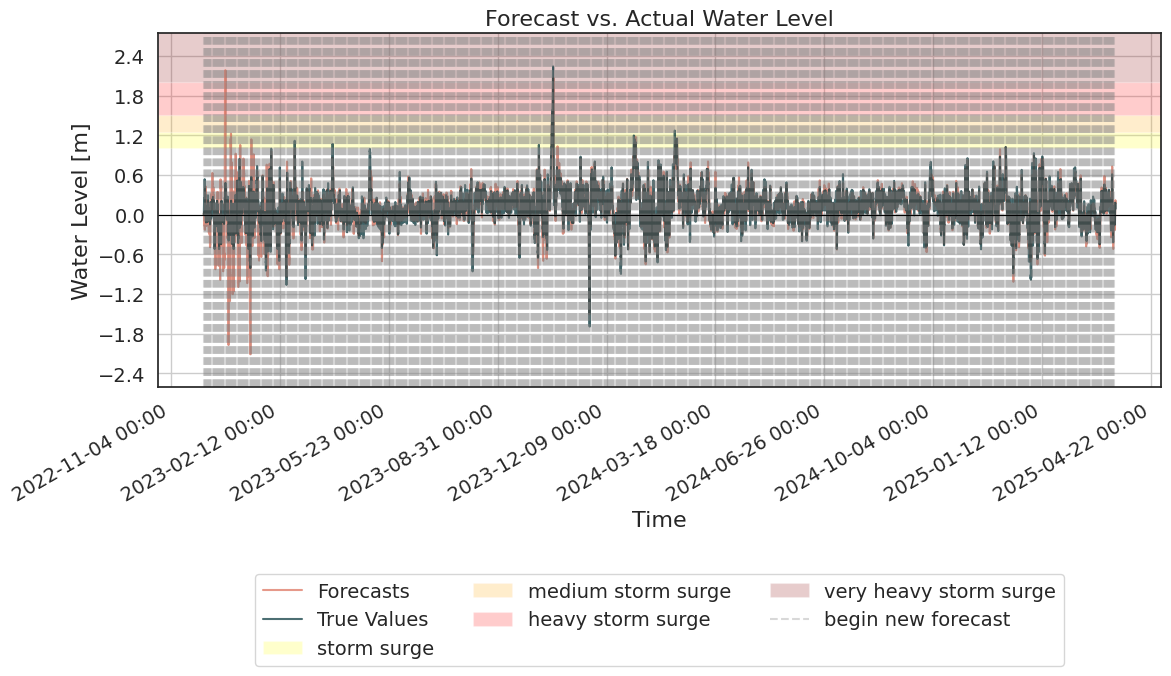

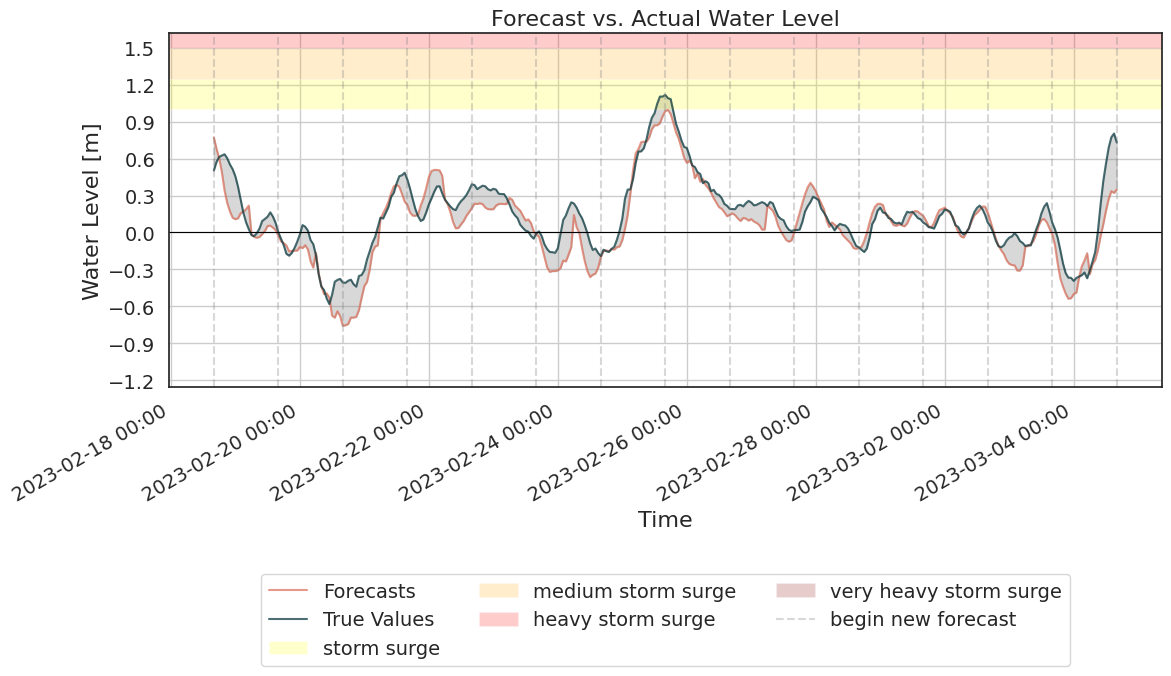

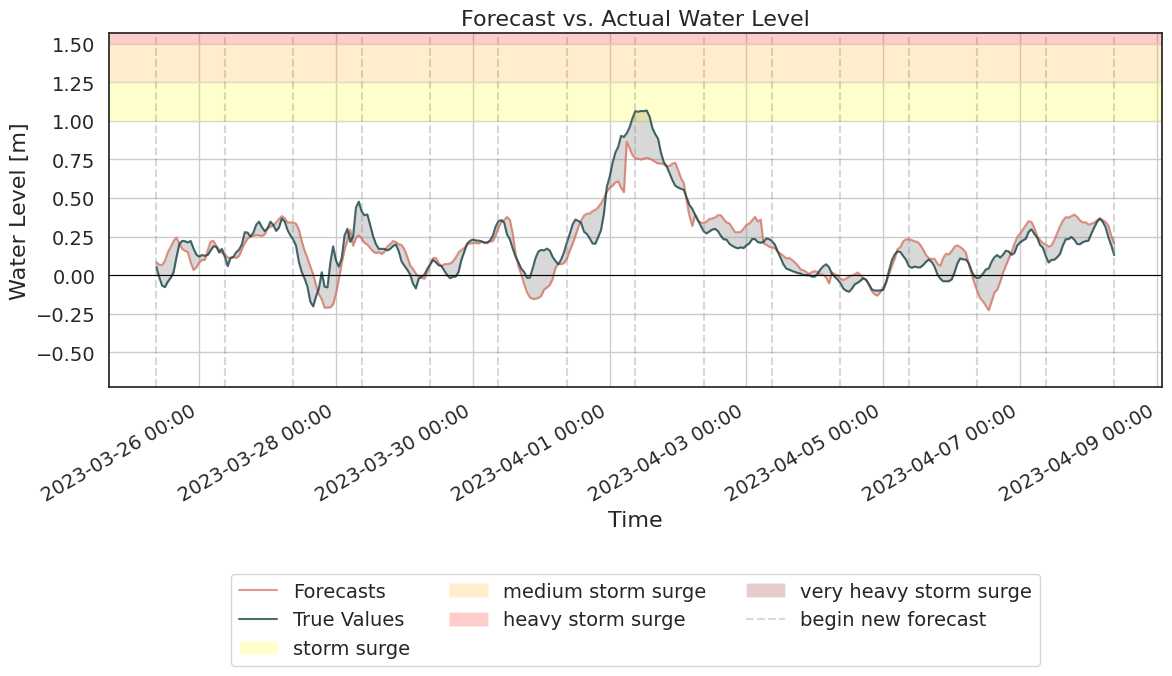

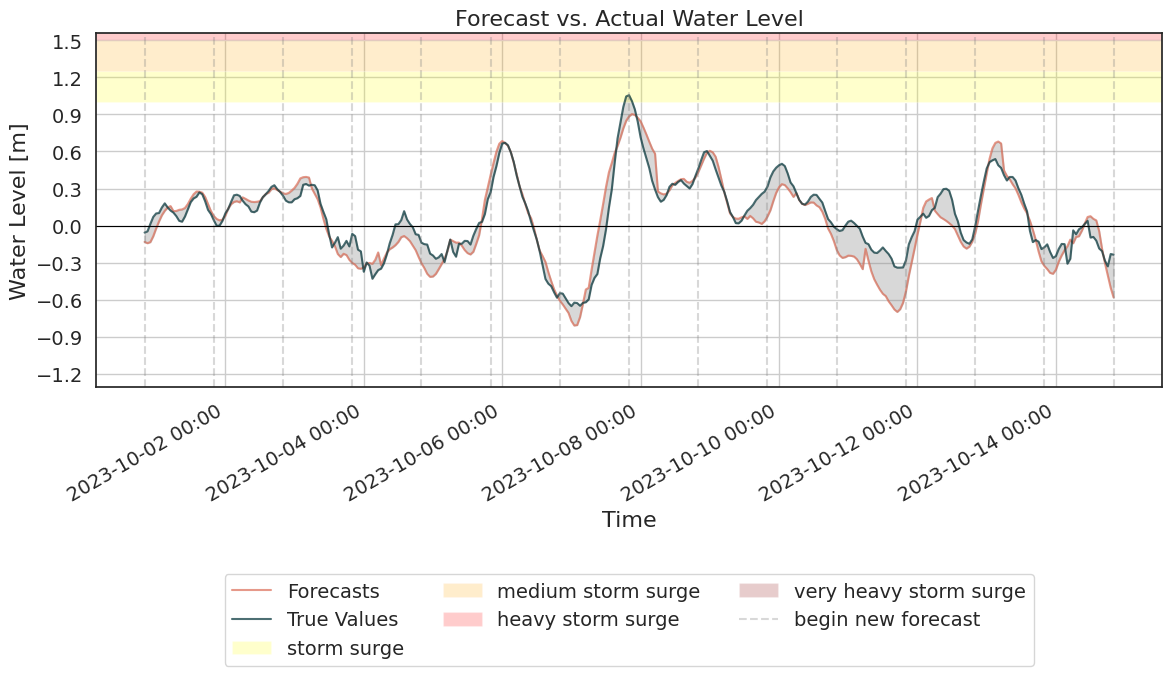

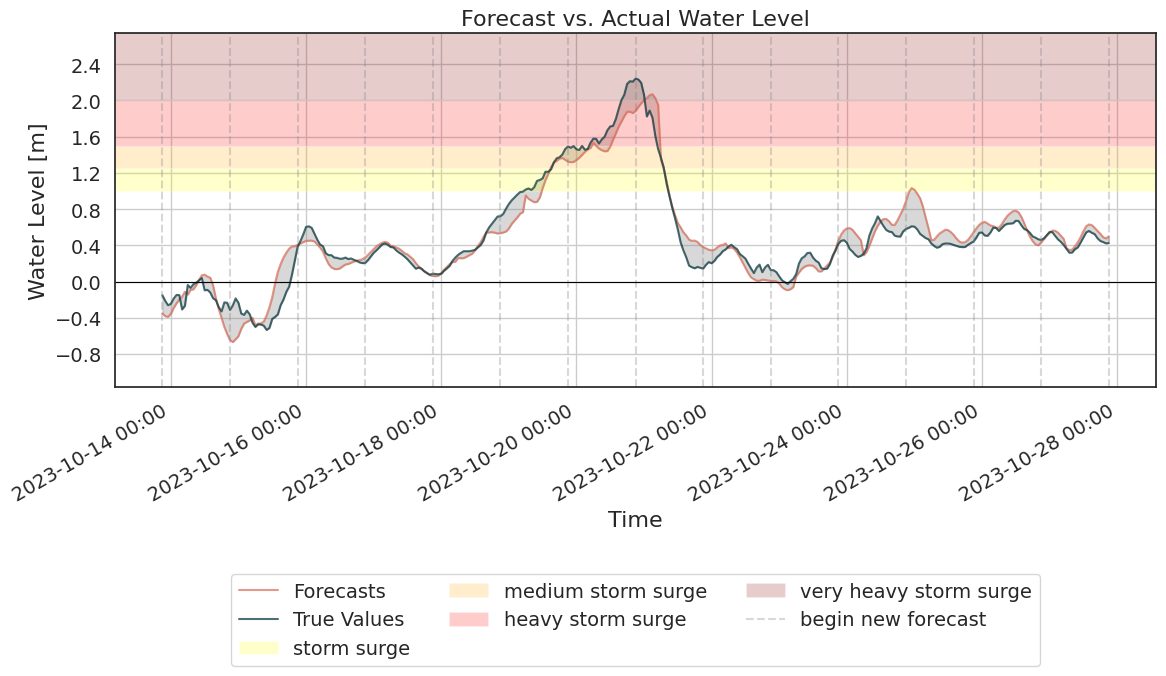

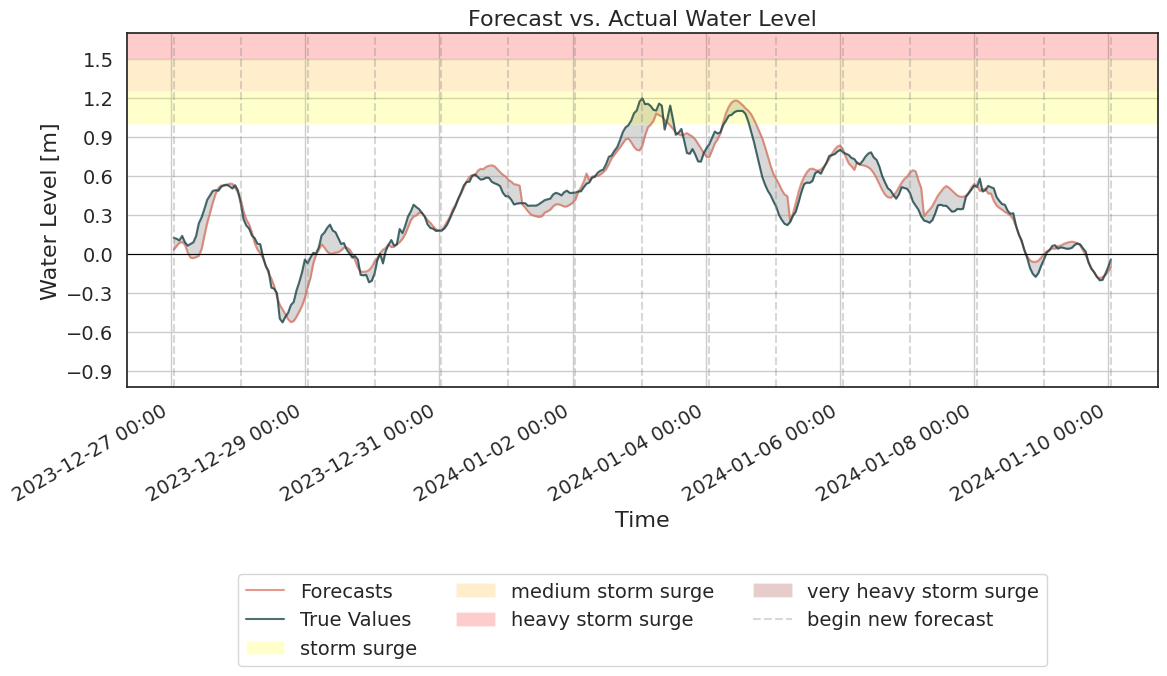

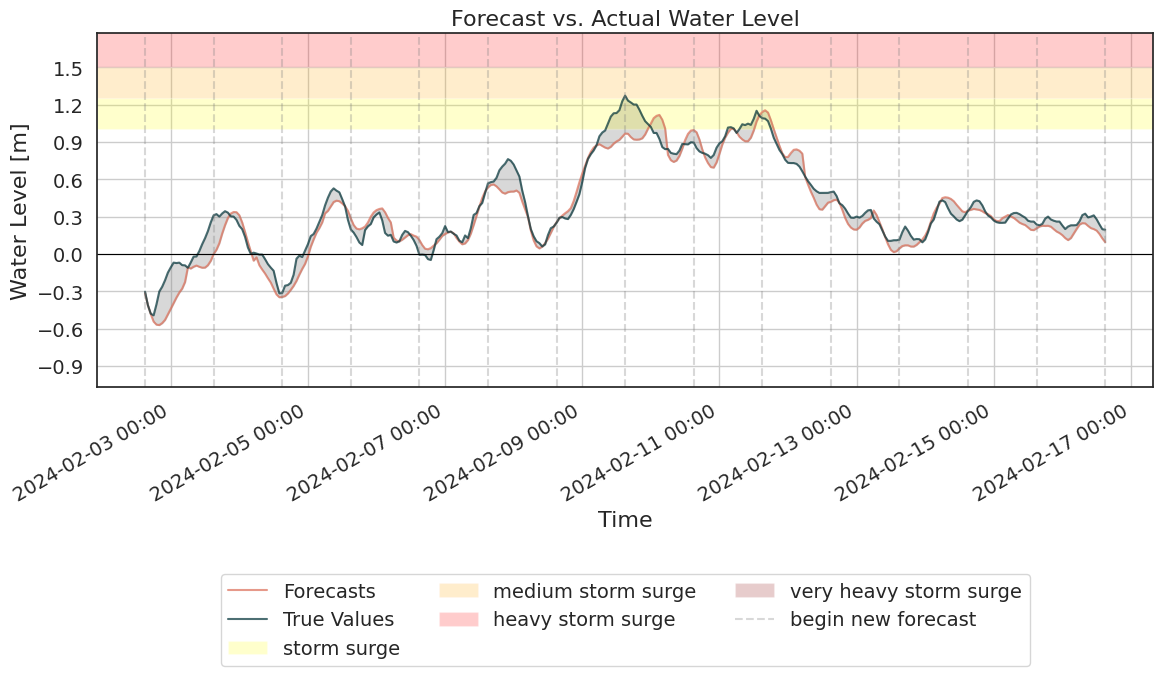

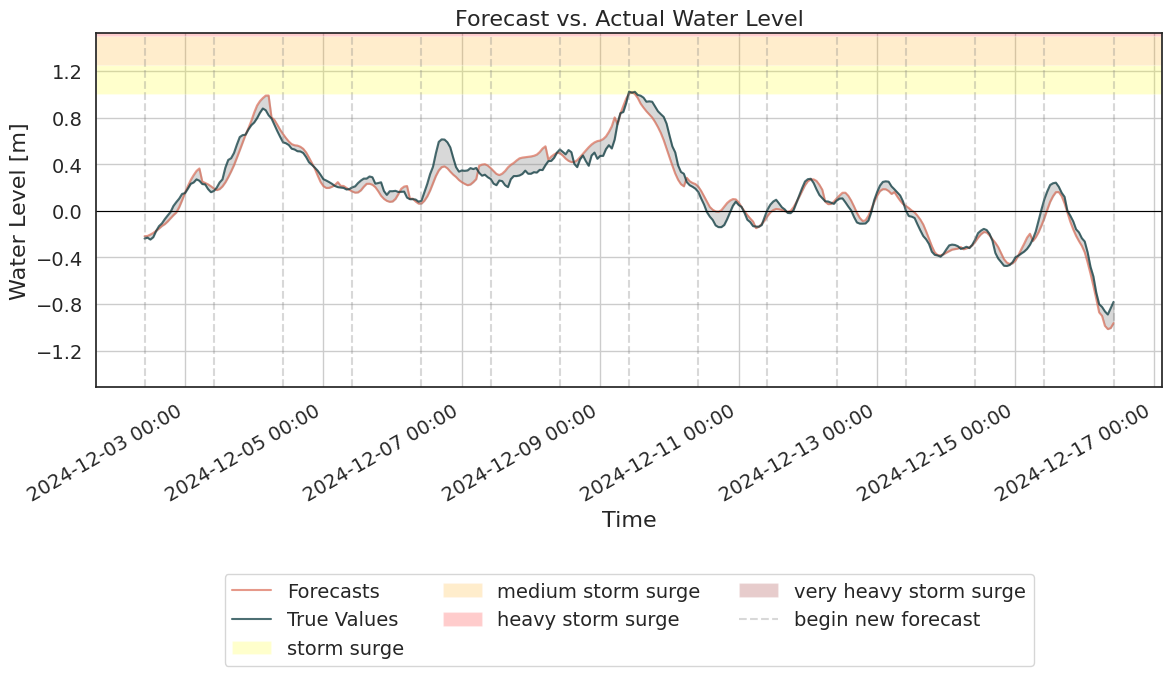

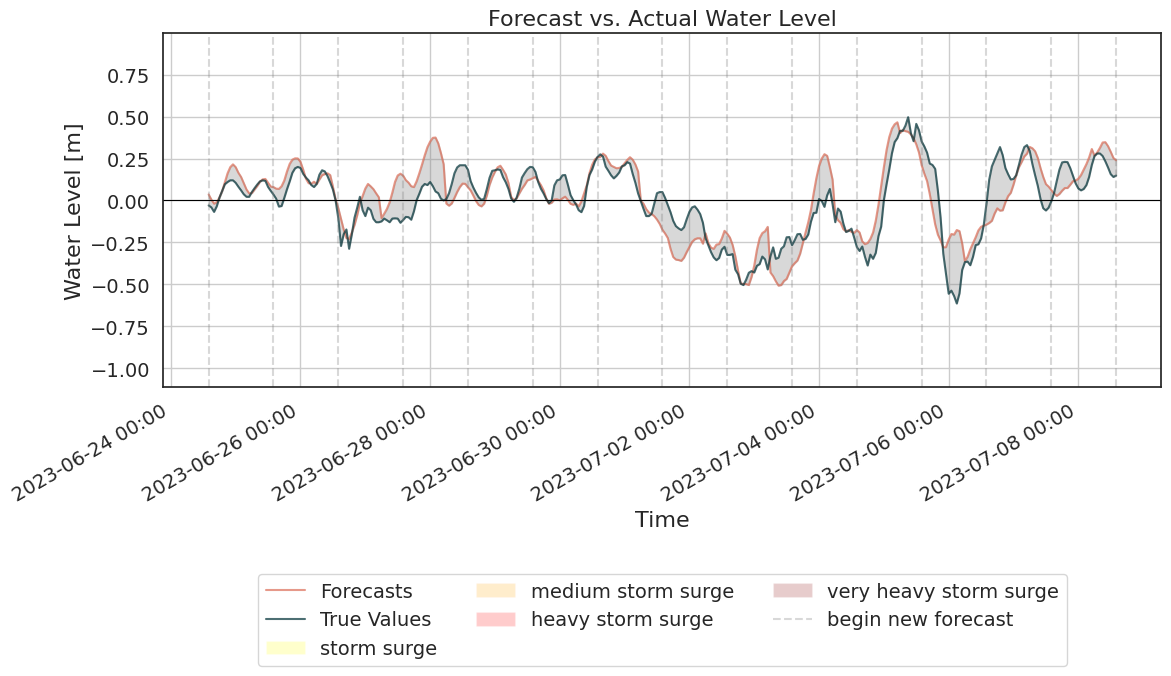

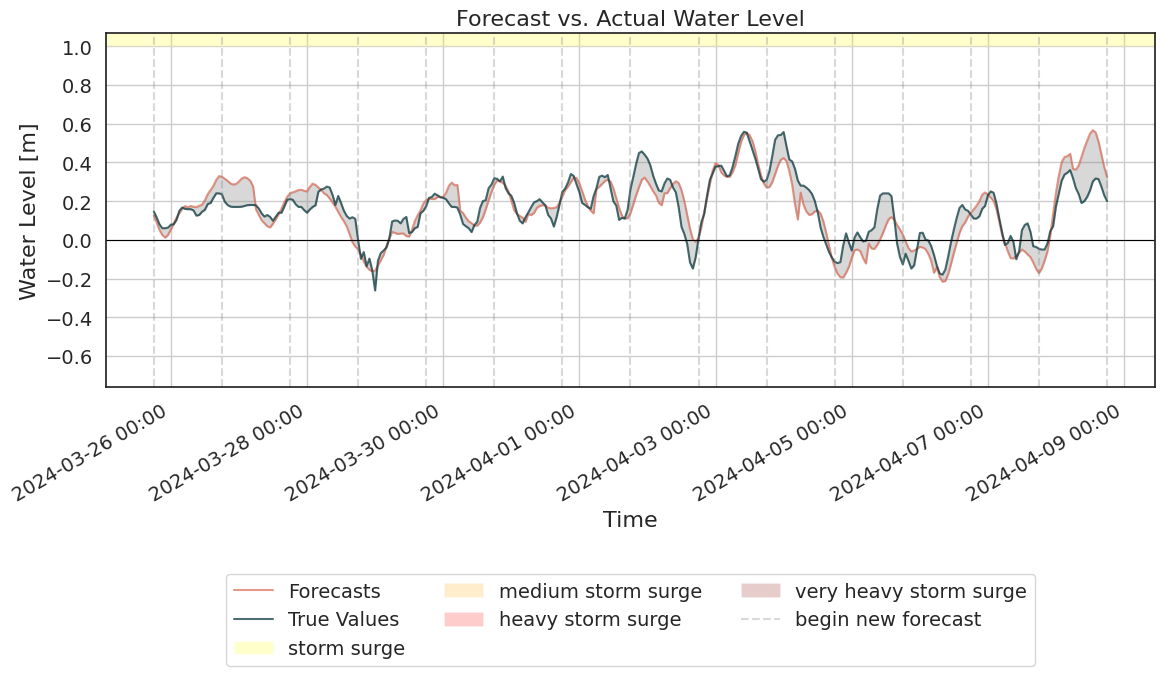

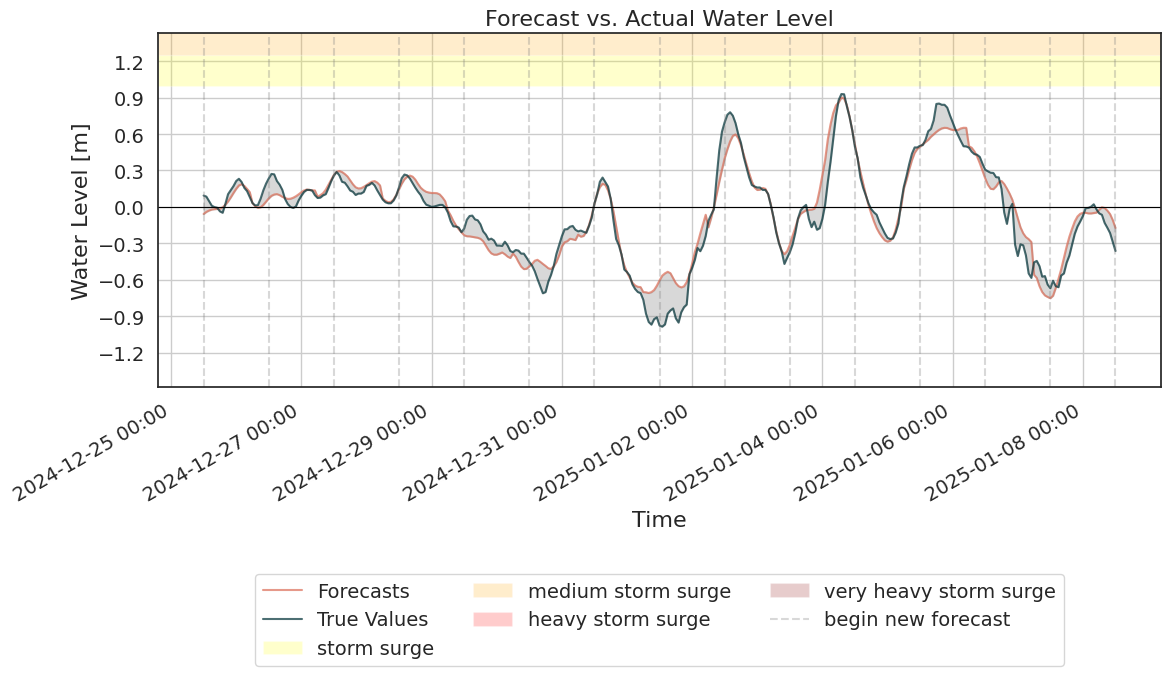

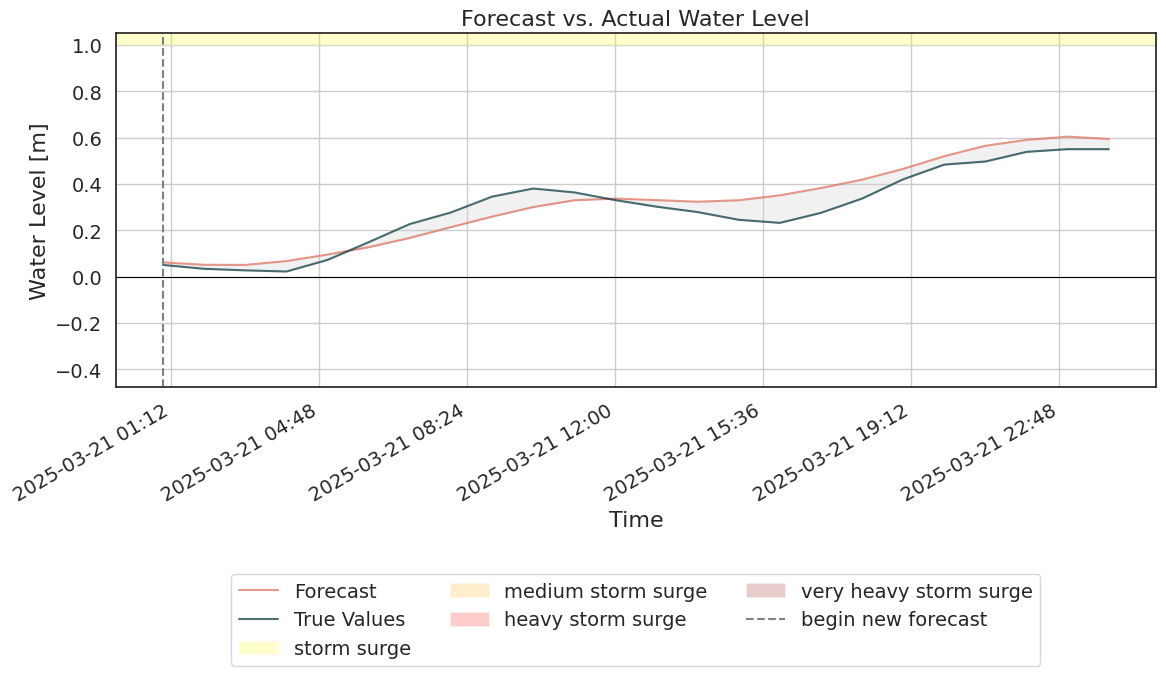

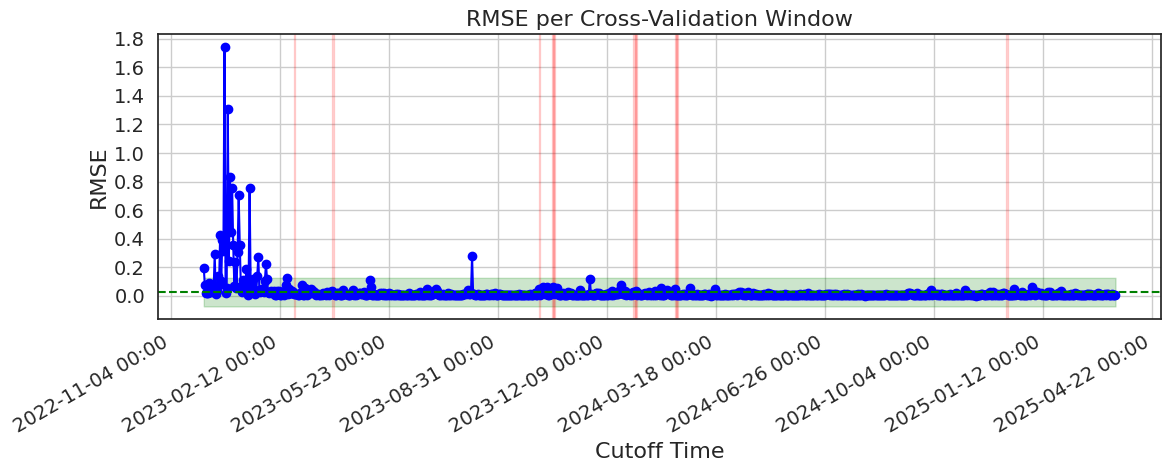

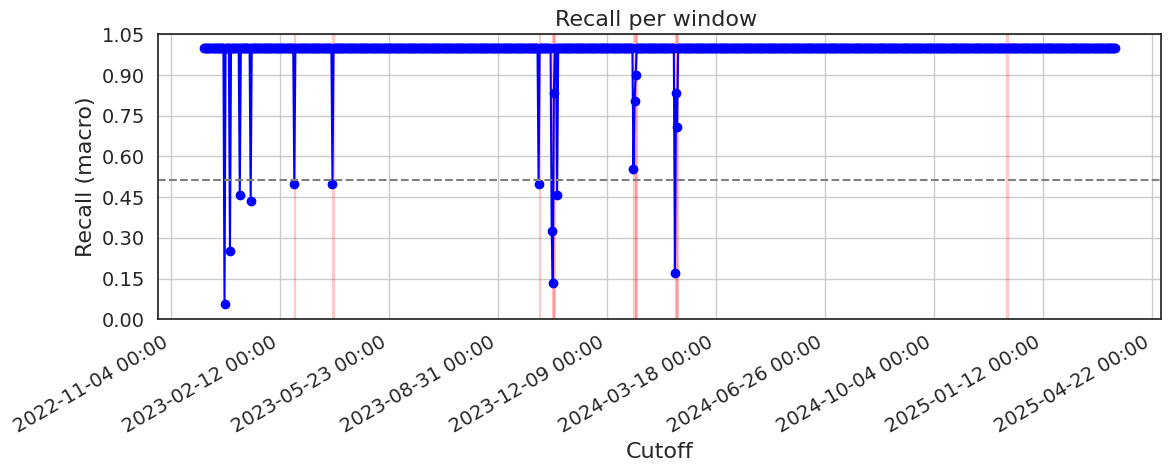

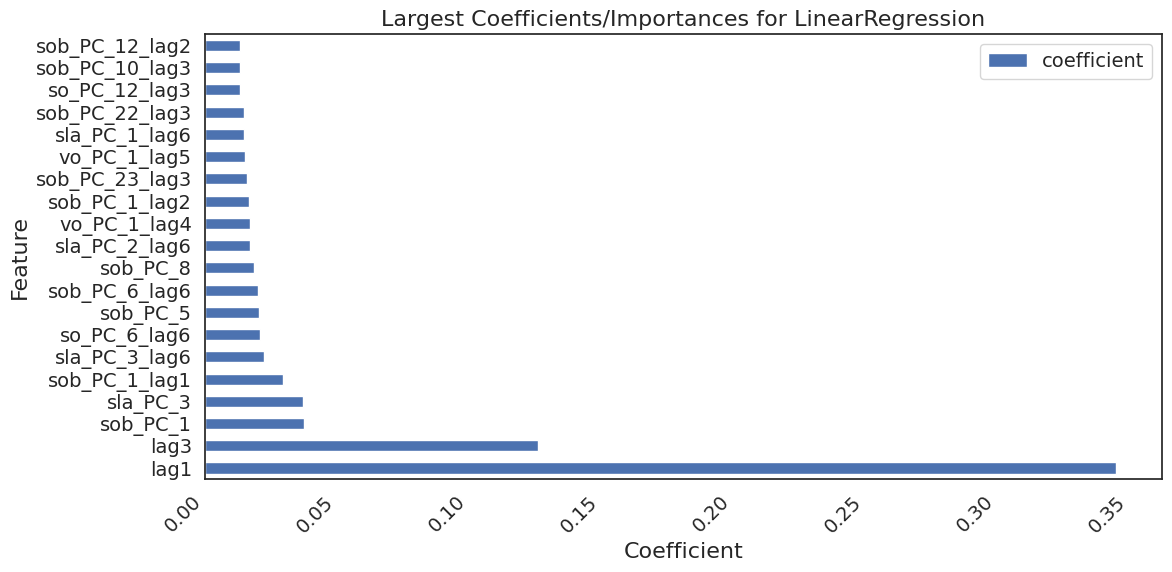

<Figure size 640x480 with 0 Axes>

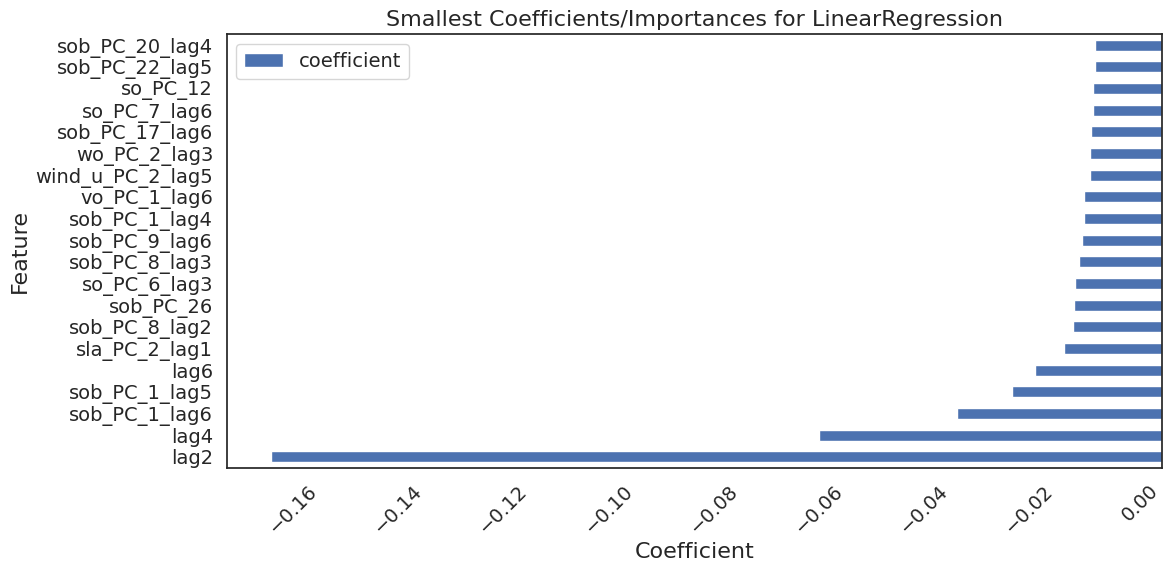

Results for Surge1 from 2023-02-18 16:00:00 to 2023-03-04 16:00:00:
Results for Surge2 from 2023-03-25 09:00:00 to 2023-04-08 09:00:00:
Results for Surge3 from 2023-09-30 20:00:00 to 2023-10-14 20:00:00:
Results for Surge4 from 2023-10-13 21:00:00 to 2023-10-27 21:00:00:
Results for Surge5 from 2023-12-27 01:00:00 to 2024-01-10 01:00:00:
Results for Surge6 from 2024-02-02 15:00:00 to 2024-02-16 15:00:00:
Results for Surge7 from 2024-12-02 10:00:00 to 2024-12-16 10:00:00:
Results for normal1 from 2023-06-24 14:00:00 to 2023-07-08 14:00:00:
Results for normal2 from 2024-03-25 18:00:00 to 2024-04-08 18:00:00:
Results for normal3 from 2024-12-25 12:00:00 to 2025-01-08 12:00:00:


Model    MSE   RMSE    MAE  Recall  Precision  Accuracy  \
0  LinearRegression  0.022  0.147  0.112   0.500      0.491     0.982   
1  LinearRegression  0.014  0.120  0.092   0.500      0.490     0.979   
2  LinearRegression  0.018  0.135  0.102   0.500      0.496     0.991   
3  LinearRegression  0.025  0.157  0.116   0.522      0.539     0.911   
4  LinearRegression  0.011  0.105  0.077   0.785      0.873     0.958   
5  LinearRegression  0.012  0.110  0.083   0.438      0.520     0.920   
6  LinearRegression  0.007  0.086  0.068   1.000      1.000     1.000   
7  LinearRegression  0.018  0.134  0.102   1.000      1.000     1.000   
8  LinearRegression  0.008  0.087  0.067   1.000      1.000     1.000   
9  LinearRegression  0.015  0.122  0.086   1.000      1.000     1.000   

   F1-Score  Avg. Fit Time (s)  Avg. Predict Time (s)  Num Params     fold  
0     0.496              2.040                  0.105           5   Surge1  
1     0.495              3.498                  0.111           5   Surge2  
2     0.498              1.309                  0.106           5   Surge3  
3     0.519              1.335                  0.114           5   Surge4  
4     0.822              1.509                  0.121           5   Surge5  
5     0.464              1.618                  0.120           5   Surge6  
6     1.000              1.867                  0.115           5   Surge7  
7     1.000              1.144                  0.111           5  normal1  
8     1.000              1.756                  0.121           5  normal2  
9     1.000              1.904                  0.112           5  normal3

MSE    RMSE     MAE  Recall  Precision  Accuracy  F1-Score  \
0  0.015  0.1203  0.0905  0.7245     0.7409    0.9741    0.7294   

   Avg. Fit Time (s)  Avg. Predict Time (s)  Num Params             Model  
0              1.798                 0.1136         5.0  LinearRegression

MSE    RMSE     MAE  Recall  Precision  Accuracy  F1-Score  \
0  0.015  0.1203  0.0905  0.7245     0.7409    0.9741    0.7294   

   Avg. Fit Time (s)  Avg. Predict Time (s)  Num Params             Model  
0              1.798                 0.1136         5.0  LinearRegression

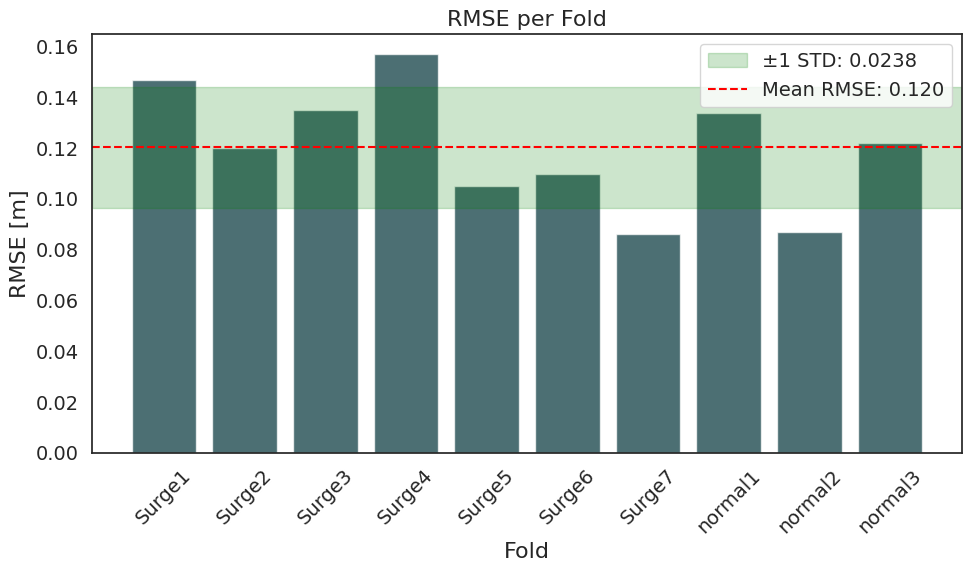

In [8]:
model = EvaluationMLModel(
    model_type='lr',  # Change this to 'xgboost', 'lgbm', 'svr', 'lr', or 'sarima'
    df=df,
    Versuch="1.1",
    h=24,
    trial_name="Versuch1")

results = model.cross_validation_results()
model_stats = model.get_model_statistics(results)
display(model_stats)
model.plot_cross_validation_results(results)
for surge_name, cutoff in folds.items():
    model.plot_cross_validation_results(results, start_date=cutoff - gap, end_date=cutoff + gap)
model.plot_test_forecast()
model.plot_rmse_per_cutoff(results)
model.plot_multiclass_recall_per_cutoff(results)
model.visualize_study()
model.plot_coefficients()

result_df = pd.DataFrame()
for surge_name, cutoff in folds.items():
    start_date = cutoff - gap
    end_date = cutoff + gap 

    results_surge = results[(results['ds'] >= start_date) & (results['ds'] <= end_date)]
    print(f"Results for {surge_name} from {start_date} to {end_date}:")
    model_surge_stats = model.get_model_statistics(results_surge)
    
    model_surge_stats['fold'] = surge_name
    result_df = pd.concat([result_df, model_surge_stats], ignore_index=True)
    model_name = model_surge_stats['Model'].iloc[0]
    
    

display(result_df)
result_df_mean = result_df.mean(numeric_only=True).to_frame().T
result_df_mean['Model'] = model_name
display(result_df_mean)
model_stats_all = pd.concat([model_stats_all, result_df_mean], ignore_index=True)
display(model_stats_all)
# BARPLOT
# plot barplot
fig = plt.figure(figsize=(10, 6))
plt.bar(result_df['fold'], result_df['RMSE'], color=TRUE_COLOR, alpha=0.7)
rmse = result_df['RMSE'].mean()
std_value = result_df['RMSE'].std()

plt.axhspan(rmse - std_value, rmse + std_value, 
            color='green', alpha=0.2, 
            label=f'±1 STD: {std_value:.4f}')
plt.axhline(rmse, color='red', linestyle='--', label=f'Mean RMSE: {rmse:.3f}')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('RMSE [m]')
plt.title('RMSE per Fold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"../thesis_plots/{model.trial_name}_ML_rmse_per_fold_{model.model_name}_h{model.h}.png", dpi=300)
plt.show()


## Light Gradient Boosting Machine

In [ ]:
model = EvaluationMLModel(
    model_type='lgbm',  # Change this to 'xgboost', 'lgbm', 'svr', 'lr', or 'sarima'
    df=df,
    Versuch="1.1",
    h=24,
    trial_name="Versuch1")

results = model.cross_validation_results()
model_stats = model.get_model_statistics(results)
display(model_stats)
model.plot_cross_validation_results(results)
for surge_name, cutoff in folds.items():
    model.plot_cross_validation_results(results, start_date=cutoff - gap, end_date=cutoff + gap, title=f"{surge_name}: Forecast vs. Actual Water Level")
model.plot_test_forecast()
model.plot_rmse_per_cutoff(results)
model.plot_multiclass_recall_per_cutoff(results)
model.visualize_study()
model.plot_coefficients()


result_df = pd.DataFrame()
for surge_name, cutoff in folds.items():
    start_date = cutoff - gap
    end_date = cutoff + gap 

    results_surge = results[(results['ds'] >= start_date) & (results['ds'] <= end_date)]
    print(f"Results for {surge_name} from {start_date} to {end_date}:")
    model_surge_stats = model.get_model_statistics(results_surge)
    
    model_surge_stats['fold'] = surge_name
    result_df = pd.concat([result_df, model_surge_stats], ignore_index=True)
    model_name = model_surge_stats['Model'].iloc[0]
    
    


display(result_df)
result_df_mean = result_df.mean(numeric_only=True).to_frame().T
result_df_mean['Model'] = model_name
display(result_df_mean)
model_stats_all = pd.concat([model_stats_all, result_df_mean], ignore_index=True)
display(model_stats_all)
# BARPLOT
# plot barplot
fig = plt.figure(figsize=(10, 6))
plt.bar(result_df['fold'], result_df['RMSE'], color=TRUE_COLOR, alpha=0.7)
rmse = result_df['RMSE'].mean()
plt.axhline(rmse, color='red', linestyle='--', label=f'Mean RMSE: {rmse:.3f}')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('RMSE [m]')
plt.title('RMSE per Fold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"../thesis_plots/{model.trial_name}_ML_rmse_per_fold_{model.model_name}_h{model.h}.png", dpi=300)
plt.show()

## XGBoost

In [ ]:
model = EvaluationMLModel(
    model_type='xgboost',  # Change this to 'xgboost', 'lgbm', 'svr', 'lr', or 'sarima'
    df=df,
    Versuch="1.1",
    h=24,
    trial_name="Versuch1")

results = model.cross_validation_results()
model_stats = model.get_model_statistics(results)
display(model_stats)
model.plot_cross_validation_results(results)
for surge_name, cutoff in folds.items():
    model.plot_cross_validation_results(results, start_date=cutoff - gap, end_date=cutoff + gap)
model.plot_test_forecast()
model.plot_rmse_per_cutoff(results)
model.plot_multiclass_recall_per_cutoff(results)
model.visualize_study()
model.plot_coefficients()

result_df = pd.DataFrame()
for surge_name, cutoff in folds.items():
    start_date = cutoff - gap
    end_date = cutoff + gap 

    results_surge = results[(results['ds'] >= start_date) & (results['ds'] <= end_date)]
    print(f"Results for {surge_name} from {start_date} to {end_date}:")
    model_surge_stats = model.get_model_statistics(results_surge)
    
    model_surge_stats['fold'] = surge_name
    result_df = pd.concat([result_df, model_surge_stats], ignore_index=True)
    model_name = model_surge_stats['Model'].iloc[0]
    
    

display(result_df)
result_df_mean = result_df.mean(numeric_only=True).to_frame().T
result_df_mean['Model'] = model_name
display(result_df_mean)
model_stats_all = pd.concat([model_stats_all, result_df_mean], ignore_index=True)
display(model_stats_all)
# BARPLOT
# plot barplot
fig = plt.figure(figsize=(10, 6))
plt.bar(result_df['fold'], result_df['RMSE'], color=TRUE_COLOR, alpha=0.7)
rmse = result_df['RMSE'].mean()
plt.axhline(rmse, color='red', linestyle='--', label=f'Mean RMSE: {rmse:.3f}')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('RMSE [m]')
plt.title('RMSE per Fold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"../thesis_plots/{model.trial_name}_ML_rmse_per_fold_{model.model_name}_h{model.h}.png", dpi=300)
plt.show()

## Random Rorest

In [ ]:
model = EvaluationMLModel(
    model_type='random_forest',  # Change this to 'xgboost', 'lgbm', 'svr', 'lr', or 'sarima', random_forest
    df=df,
    Versuch="1.1",
    h=24,
    trial_name="Versuch1")

results = model.cross_validation_results()
model_stats = model.get_model_statistics(results)
display(model_stats)
model.plot_cross_validation_results(results)
for surge_name, cutoff in folds.items():
    model.plot_cross_validation_results(results, start_date=cutoff - gap, end_date=cutoff + gap)
model.plot_test_forecast()
model.plot_rmse_per_cutoff(results)
model.plot_multiclass_recall_per_cutoff(results)
model.visualize_study()
model.plot_coefficients()

result_df = pd.DataFrame()
for surge_name, cutoff in folds.items():
    start_date = cutoff - gap
    end_date = cutoff + gap 

    results_surge = results[(results['ds'] >= start_date) & (results['ds'] <= end_date)]
    print(f"Results for {surge_name} from {start_date} to {end_date}:")
    model_surge_stats = model.get_model_statistics(results_surge)
    
    model_surge_stats['fold'] = surge_name
    result_df = pd.concat([result_df, model_surge_stats], ignore_index=True)
    model_name = model_surge_stats['Model'].iloc[0]
    
    

display(result_df)
result_df_mean = result_df.mean(numeric_only=True).to_frame().T
result_df_mean['Model'] = model_name
display(result_df_mean)
model_stats_all = pd.concat([model_stats_all, result_df_mean], ignore_index=True)
display(model_stats_all)
# BARPLOT
# plot barplot
fig = plt.figure(figsize=(10, 6))
plt.bar(result_df['fold'], result_df['RMSE'], color=TRUE_COLOR, alpha=0.7)
rmse = result_df['RMSE'].mean()
plt.axhline(rmse, color='red', linestyle='--', label=f'Mean RMSE: {rmse:.3f}')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('RMSE [m]')
plt.title('RMSE per Fold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"../thesis_plots/{model.trial_name}_ML_rmse_per_fold_{model.model_name}_h{model.h}.png", dpi=300)
plt.show()

## Sarima

In [ ]:
model = EvaluationMLModel(
    model_type='sarima',  # Change this to 'xgboost', 'lgbm', 'svr', 'lr', or 'sarima', random_forest
    df=df,
    Versuch="1.1",
    h=24,
    trial_name="Versuch1")

results = model.cross_validation_results()
model_stats = model.get_model_statistics(results)
display(model_stats)
model.plot_cross_validation_results(results)
for surge_name, cutoff in folds.items():
    model.plot_cross_validation_results(results, start_date=cutoff - gap, end_date=cutoff + gap)
model.plot_test_forecast()
model.plot_rmse_per_cutoff(results)
model.plot_multiclass_recall_per_cutoff(results)
model.visualize_study()
model.plot_coefficients()

result_df = pd.DataFrame()
for surge_name, cutoff in folds.items():
    start_date = cutoff - gap
    end_date = cutoff + gap 

    results_surge = results[(results['ds'] >= start_date) & (results['ds'] <= end_date)]
    print(f"Results for {surge_name} from {start_date} to {end_date}:")
    model_surge_stats = model.get_model_statistics(results_surge)
    
    model_surge_stats['fold'] = surge_name
    result_df = pd.concat([result_df, model_surge_stats], ignore_index=True)
    model_name = model_surge_stats['Model'].iloc[0]
    
    

display(result_df)
result_df_mean = result_df.mean(numeric_only=True).to_frame().T
result_df_mean['Model'] = model_name
display(result_df_mean)
model_stats_all = pd.concat([model_stats_all, result_df_mean], ignore_index=True)
display(model_stats_all)
# BARPLOT
# plot barplot
fig = plt.figure(figsize=(10, 6))
plt.bar(result_df['fold'], result_df['RMSE'], color=TRUE_COLOR, alpha=0.7)
rmse = result_df['RMSE'].mean()
plt.axhline(rmse, color='red', linestyle='--', label=f'Mean RMSE: {rmse:.3f}')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('RMSE [m]')
plt.title('RMSE per Fold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"../thesis_plots/{model.trial_name}_ML_rmse_per_fold_{model.model_name}_h{model.h}.png", dpi=300)
plt.show()

## Support Vector Regression

In [ ]:
model = EvaluationMLModel(
    model_type='svr',  # Change this to 'xgboost', 'lgbm', 'svr', 'lr', or 'sarima', random_forest
    df=df,
    Versuch="1.1",
    h=24,
    trial_name="Versuch1")

results = model.cross_validation_results()
model_stats = model.get_model_statistics(results)
display(model_stats)
model.plot_cross_validation_results(results)
for surge_name, cutoff in folds.items():
    model.plot_cross_validation_results(results, start_date=cutoff - gap, end_date=cutoff + gap)
model.plot_test_forecast()
model.plot_rmse_per_cutoff(results)
model.plot_multiclass_recall_per_cutoff(results)
model.visualize_study()
model.plot_coefficients()

result_df = pd.DataFrame()
for surge_name, cutoff in folds.items():
    start_date = cutoff - gap
    end_date = cutoff + gap 

    results_surge = results[(results['ds'] >= start_date) & (results['ds'] <= end_date)]
    print(f"Results for {surge_name} from {start_date} to {end_date}:")
    model_surge_stats = model.get_model_statistics(results_surge)
    
    model_surge_stats['fold'] = surge_name
    result_df = pd.concat([result_df, model_surge_stats], ignore_index=True)
    model_name = model_surge_stats['Model'].iloc[0]
    
    


display(result_df)
result_df_mean = result_df.mean(numeric_only=True).to_frame().T
result_df_mean['Model'] = model_name
display(result_df_mean)
model_stats_all = pd.concat([model_stats_all, result_df_mean], ignore_index=True)
display(model_stats_all)
# BARPLOT
# plot barplot
fig = plt.figure(figsize=(10, 6))
plt.bar(result_df['fold'], result_df['RMSE'], color=TRUE_COLOR, alpha=0.7)
rmse = result_df['RMSE'].mean()
plt.axhline(rmse, color='red', linestyle='--', label=f'Mean RMSE: {rmse:.3f}')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('RMSE [m]')
plt.title('RMSE per Fold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"../thesis_plots/{model.trial_name}_ML_rmse_per_fold_{model.model_name}_h{model.h}.png", dpi=300)
plt.show()

['SVR_points30_h168_ml_test', 'SVR_points30_h24_ml_test']


ds  bottomT_PC_1  bottomT_PC_2  bottomT_PC_3  bottomT_PC_4  \
0 2022-12-03 00:00:00     -0.303945     -1.571631     -0.796631      0.568800   
1 2022-12-03 01:00:00     -0.305888     -1.570625     -0.795225      0.571684   
2 2022-12-03 02:00:00     -0.306904     -1.571336     -0.795739      0.570574   
3 2022-12-03 03:00:00     -0.308250     -1.573073     -0.795607      0.568620   
4 2022-12-03 04:00:00     -0.309479     -1.574358     -0.794477      0.567034   

   sla_PC_1  sla_PC_2  sla_PC_3   so_PC_1   so_PC_2   so_PC_3   so_PC_4  \
0 -1.005268 -0.822924  0.530070 -0.218220 -0.897083  0.492402 -1.479749   
1 -1.002811 -0.833910  0.528256 -0.210618 -0.893305  0.481362 -1.521018   
2 -1.006549 -0.904703  0.446098 -0.205510 -0.893562  0.476674 -1.559010   
3 -1.015887 -1.027999  0.293744 -0.205313 -0.898010  0.477123 -1.594605   
4 -1.026219 -1.160469  0.123971 -0.204544 -0.909398  0.471819 -1.619637   

    so_PC_5   so_PC_6   so_PC_7   so_PC_8   so_PC_9  so_PC_10  so_PC_11  \
0  1.945935 -1.708837  0.830561  0.660026  0.225722 -0.037684 -1.047863   
1  1.944044 -1.712570  0.832452  0.601833  0.220957 -0.069068 -1.055865   
2  1.944211 -1.724287  0.846148  0.536701  0.206006 -0.078033 -1.056282   
3  1.938970 -1.735312  0.855395  0.473940  0.159578 -0.082558 -1.079618   
4  1.939357 -1.744318  0.862890  0.425579  0.107285 -0.084850 -1.130310   

   so_PC_12  so_PC_13  so_PC_14  so_PC_15  so_PC_16  so_PC_17  so_PC_18  \
0  0.151338  0.904935  0.266220  1.443508  0.784207  0.407340  1.257197   
1  0.110541  0.909764  0.278798  1.370188  0.752076  0.372693  1.250635   
2  0.085108  0.891672  0.270216  1.303007  0.736780  0.342056  1.274352   
3  0.073794  0.872644  0.246432  1.249117  0.761749  0.329968  1.322249   
4  0.053449  0.843531  0.238551  1.199902  0.797326  0.316378  1.390427   

   so_PC_19  so_PC_20  so_PC_21  sob_PC_1  sob_PC_2  sob_PC_3  sob_PC_4  \
0  1.615682  0.082208  0.839712  0.264553  0.254636 -1.669036  0.791188   
1  1.550921  0.082548  0.713609  0.259735  0.271430 -1.669632  0.789600   
2  1.523114  0.057399  0.650072  0.256050  0.284954 -1.667553  0.789894   
3  1.504705 -0.002460  0.665214  0.254308  0.291983 -1.664166  0.784284   
4  1.485329 -0.068221  0.715472  0.254585  0.297858 -1.660127  0.783129   

   sob_PC_5  sob_PC_6  sob_PC_7  sob_PC_8  sob_PC_9  sob_PC_10  sob_PC_11  \
0 -0.179636  0.022623  0.643463 -0.607757 -2.275575  -0.271110   2.232440   
1 -0.226949  0.082152  0.661515 -0.607035 -2.254747  -0.248653   2.227916   
2 -0.262441  0.130412  0.681979 -0.602594 -2.231523  -0.236153   2.221946   
3 -0.283047  0.170041  0.700163 -0.598078 -2.207416  -0.228100   2.214447   
4 -0.294301  0.188554  0.711769 -0.597417 -2.183183  -0.213062   2.206021   

   sob_PC_12  sob_PC_13  sob_PC_14  sob_PC_15  sob_PC_16  sob_PC_17  \
0   2.175432   1.667905  -1.114560   1.036917  -0.649352   0.085947   
1   2.186811   1.623602  -1.106727   0.991440  -0.647355   0.070829   
2   2.199752   1.607716  -1.141528   0.905202  -0.641713   0.067386   
3   2.208812   1.611233  -1.192685   0.813053  -0.635158   0.079425   
4   2.224724   1.645976  -1.264315   0.699793  -0.643793   0.105970   

   sob_PC_18  sob_PC_19  sob_PC_20  sob_PC_21  sob_PC_22  sob_PC_23  \
0   0.039516   0.149573   1.011663   0.578998  -1.767117  -0.969698   
1  -0.006989   0.095796   0.979036   0.573021  -1.714309  -1.045219   
2  -0.032400   0.034161   0.940107   0.564657  -1.674537  -1.113952   
3  -0.049929  -0.010915   0.888790   0.546142  -1.653721  -1.153607   
4  -0.057998  -0.042699   0.830250   0.521896  -1.639177  -1.151354   

   sob_PC_24  sob_PC_25  sob_PC_26  thetao_PC_1   uo_PC_1   vo_PC_1   wo_PC_1  \
0   2.975066  -0.136664   0.596100    -0.332200 -1.676010 -0.916467 -0.988585   
1   3.015842  -0.200679   0.572013    -0.337065 -1.672298 -0.883804 -0.892139   
2   3.037881  -0.231346   0.522573    -0.338199 -1.682788 -0.840234 -0.873372   
3   3.020837  -0.239250   0.468367    -0.339460 -1.682179 -0.816337 -0.875945   
4   2.

['ds', 'bottomT_PC_1', 'bottomT_PC_2', 'bottomT_PC_3', 'bottomT_PC_4', 'sla_PC_1', 'sla_PC_2', 'sla_PC_3', 'so_PC_1', 'so_PC_2', 'so_PC_3', 'so_PC_4', 'so_PC_5', 'so_PC_6', 'so_PC_7', 'so_PC_8', 'so_PC_9', 'so_PC_10', 'so_PC_11', 'so_PC_12', 'so_PC_13', 'so_PC_14', 'so_PC_15', 'so_PC_16', 'so_PC_17', 'so_PC_18', 'so_PC_19', 'so_PC_20', 'so_PC_21', 'sob_PC_1', 'sob_PC_2', 'sob_PC_3', 'sob_PC_4', 'sob_PC_5', 'sob_PC_6', 'sob_PC_7', 'sob_PC_8', 'sob_PC_9', 'sob_PC_10', 'sob_PC_11', 'sob_PC_12', 'sob_PC_13', 'sob_PC_14', 'sob_PC_15', 'sob_PC_16', 'sob_PC_17', 'sob_PC_18', 'sob_PC_19', 'sob_PC_20', 'sob_PC_21', 'sob_PC_22', 'sob_PC_23', 'sob_PC_24', 'sob_PC_25', 'sob_PC_26', 'thetao_PC_1', 'uo_PC_1', 'vo_PC_1', 'wo_PC_1', 'wo_PC_2', 'wo_PC_3', 'wo_PC_4', 'wo_PC_5', 'wo_PC_6', 'wo_PC_7', 'pressure_msl_PC_1', 'pressure_msl_PC_2', 'surface_pressure_PC_1', 'surface_pressure_PC_2', 'wind_gusts_10m_PC_1', 'wind_gusts_10m_PC_2', 'wind_gusts_10m_PC_3', 'wind_gusts_10m_PC_4', 'wind_gusts_10m_PC_5', 

MLForecast CV mit Zeitmessung:  85%|████████▌ | 734/860 [5:31:37<2:50:39, 81.26s/it]

In [ ]:
display(model_stats_all)

In [ ]:
display(model_stats_all.sort_values(by='MAE', ascending=True))
display(model_stats_all.sort_values(by='Recall', ascending=False))
model_stats_all.to_csv(model_stats_all, "../thesis_plots/Versuch1_ML_model_statistics_all_models.csv", index=False)

In [ ]:
dd

# Versuch 2

## Load Data

In [ ]:
df = load_data_v2()

In [ ]:
df.info()

In [ ]:
model_stats_all = pd.DataFrame()

## Linear Regression

In [ ]:
model = EvaluationMLModel(
    model_type='lr',  # Change this to 'xgboost', 'lgbm', 'svr', 'lr', or 'sarima'
    df=df,
    Versuch="2",
    h=24,
    trial_name="Versuch2")

results = model.cross_validation_results()
model_stats = model.get_model_statistics(results)
display(model_stats)
model.plot_cross_validation_results(results)
for surge_name, cutoff in folds.items():
    model.plot_cross_validation_results(results, start_date=cutoff - gap, end_date=cutoff + gap)
model.plot_test_forecast()
model.plot_rmse_per_cutoff(results)
model.plot_multiclass_recall_per_cutoff(results)
model.visualize_study()
model.plot_coefficients()

result_df = pd.DataFrame()
for surge_name, cutoff in folds.items():
    start_date = cutoff - gap
    end_date = cutoff + gap 

    results_surge = results[(results['ds'] >= start_date) & (results['ds'] <= end_date)]
    print(f"Results for {surge_name} from {start_date} to {end_date}:")
    model_surge_stats = model.get_model_statistics(results_surge)
    
    model_surge_stats['fold'] = surge_name
    result_df = pd.concat([result_df, model_surge_stats], ignore_index=True)
    model_name = model_surge_stats['Model'].iloc[0]
    
    


result_df = result_df.mean(numeric_only=True).to_frame().T
result_df['Model'] = model_name
display(result_df)
model_stats_all = pd.concat([model_stats_all, result_df], ignore_index=True)
display(model_stats_all)

## Light Gradient Boosting Machine

In [ ]:
model = EvaluationMLModel(
    model_type='lgbm',  # Change this to 'xgboost', 'lgbm', 'svr', 'lr', or 'sarima'
    df=df,
    Versuch="2",
    h=24,
    trial_name="Versuch2")

results = model.cross_validation_results()
model_stats = model.get_model_statistics(results)
display(model_stats)
model.plot_cross_validation_results(results)
for surge_name, cutoff in folds.items():
    model.plot_cross_validation_results(results, start_date=cutoff - gap, end_date=cutoff + gap)
model.plot_test_forecast()
model.plot_rmse_per_cutoff(results)
model.plot_multiclass_recall_per_cutoff(results)
model.visualize_study()
model.plot_coefficients()

result_df = pd.DataFrame()
for surge_name, cutoff in folds.items():
    start_date = cutoff - gap
    end_date = cutoff + gap 

    results_surge = results[(results['ds'] >= start_date) & (results['ds'] <= end_date)]
    print(f"Results for {surge_name} from {start_date} to {end_date}:")
    model_surge_stats = model.get_model_statistics(results_surge)
    
    model_surge_stats['fold'] = surge_name
    result_df = pd.concat([result_df, model_surge_stats], ignore_index=True)
    model_name = model_surge_stats['Model'].iloc[0]
    
    


display(result_df)
result_df_mean = result_df.mean(numeric_only=True).to_frame().T
result_df_mean['Model'] = model_name
display(result_df_mean)
model_stats_all = pd.concat([model_stats_all, result_df_mean], ignore_index=True)
display(model_stats_all)
# BARPLOT
# plot barplot
fig = plt.figure(figsize=(10, 6))
plt.bar(result_df['fold'], result_df['RMSE'], color=TRUE_COLOR, alpha=0.7)
rmse = result_df['RMSE'].mean()
plt.axhline(rmse, color='red', linestyle='--', label=f'Mean RMSE: {rmse:.3f}')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('RMSE [m]')
plt.title('RMSE per Fold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"../thesis_plots/{model.trial_name}_ML_rmse_per_fold_{model.model_name}_h{model.h}.png", dpi=300)
plt.show()

## XGBoost

In [ ]:
model = EvaluationMLModel(
    model_type='xgboost',  # Change this to 'xgboost', 'lgbm', 'svr', 'lr', or 'sarima'
    df=df,
    Versuch="2",
    h=24,
    trial_name="Versuch2")

results = model.cross_validation_results()
model_stats = model.get_model_statistics(results)
display(model_stats)
model.plot_cross_validation_results(results)
for surge_name, cutoff in folds.items():
    model.plot_cross_validation_results(results, start_date=cutoff - gap, end_date=cutoff + gap)
model.plot_test_forecast()
model.plot_rmse_per_cutoff(results)
model.plot_multiclass_recall_per_cutoff(results)
model.visualize_study()
model.plot_coefficients()

result_df = pd.DataFrame()
for surge_name, cutoff in folds.items():
    start_date = cutoff - gap
    end_date = cutoff + gap 

    results_surge = results[(results['ds'] >= start_date) & (results['ds'] <= end_date)]
    print(f"Results for {surge_name} from {start_date} to {end_date}:")
    model_surge_stats = model.get_model_statistics(results_surge)
    
    model_surge_stats['fold'] = surge_name
    result_df = pd.concat([result_df, model_surge_stats], ignore_index=True)
    model_name = model_surge_stats['Model'].iloc[0]
    
    


display(result_df)
result_df_mean = result_df.mean(numeric_only=True).to_frame().T
result_df_mean['Model'] = model_name
display(result_df_mean)
model_stats_all = pd.concat([model_stats_all, result_df_mean], ignore_index=True)
display(model_stats_all)
# BARPLOT
# plot barplot
fig = plt.figure(figsize=(10, 6))
plt.bar(result_df['fold'], result_df['RMSE'], color=TRUE_COLOR, alpha=0.7)
rmse = result_df['RMSE'].mean()
plt.axhline(rmse, color='red', linestyle='--', label=f'Mean RMSE: {rmse:.3f}')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('RMSE [m]')
plt.title('RMSE per Fold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"../thesis_plots/{model.trial_name}_ML_rmse_per_fold_{model.model_name}_h{model.h}.png", dpi=300)
plt.show()

## Random Rorest

In [ ]:
model = EvaluationMLModel(
    model_type='random_forest',  # Change this to 'xgboost', 'lgbm', 'svr', 'lr', or 'sarima'
    df=df,
    Versuch="2",
    h=24,
    trial_name="Versuch2")

results = model.cross_validation_results()
model_stats = model.get_model_statistics(results)
display(model_stats)
model.plot_cross_validation_results(results)
for surge_name, cutoff in folds.items():
    model.plot_cross_validation_results(results, start_date=cutoff - gap, end_date=cutoff + gap)
model.plot_test_forecast()
model.plot_rmse_per_cutoff(results)
model.plot_multiclass_recall_per_cutoff(results)
model.visualize_study()
model.plot_coefficients()

result_df = pd.DataFrame()
for surge_name, cutoff in folds.items():
    start_date = cutoff - gap
    end_date = cutoff + gap 

    results_surge = results[(results['ds'] >= start_date) & (results['ds'] <= end_date)]
    print(f"Results for {surge_name} from {start_date} to {end_date}:")
    model_surge_stats = model.get_model_statistics(results_surge)
    
    model_surge_stats['fold'] = surge_name
    result_df = pd.concat([result_df, model_surge_stats], ignore_index=True)
    model_name = model_surge_stats['Model'].iloc[0]
    
    

display(result_df)
result_df_mean = result_df.mean(numeric_only=True).to_frame().T
result_df_mean['Model'] = model_name
display(result_df_mean)
model_stats_all = pd.concat([model_stats_all, result_df_mean], ignore_index=True)
display(model_stats_all)
# BARPLOT
# plot barplot
fig = plt.figure(figsize=(10, 6))
plt.bar(result_df['fold'], result_df['RMSE'], color=TRUE_COLOR, alpha=0.7)
rmse = result_df['RMSE'].mean()
plt.axhline(rmse, color='red', linestyle='--', label=f'Mean RMSE: {rmse:.3f}')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('RMSE [m]')
plt.title('RMSE per Fold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"../thesis_plots/{model.trial_name}_ML_rmse_per_fold_{model.model_name}_h{model.h}.png", dpi=300)
plt.show()

## Sarima

In [ ]:
model = EvaluationMLModel(
    model_type='sarima',  # Change this to 'xgboost', 'lgbm', 'svr', 'lr', or 'sarima'
    df=df,
    Versuch="2",
    h=24,
    trial_name="Versuch2")

results = model.cross_validation_results()
model_stats = model.get_model_statistics(results)
display(model_stats)
model.plot_cross_validation_results(results)
for surge_name, cutoff in folds.items():
    model.plot_cross_validation_results(results, start_date=cutoff - gap, end_date=cutoff + gap)
model.plot_test_forecast()
model.plot_rmse_per_cutoff(results)
model.plot_multiclass_recall_per_cutoff(results)
model.visualize_study()
model.plot_coefficients()

result_df = pd.DataFrame()
for surge_name, cutoff in folds.items():
    start_date = cutoff - gap
    end_date = cutoff + gap 

    results_surge = results[(results['ds'] >= start_date) & (results['ds'] <= end_date)]
    print(f"Results for {surge_name} from {start_date} to {end_date}:")
    model_surge_stats = model.get_model_statistics(results_surge)
    
    model_surge_stats['fold'] = surge_name
    result_df = pd.concat([result_df, model_surge_stats], ignore_index=True)
    model_name = model_surge_stats['Model'].iloc[0]
    
    


display(result_df)
result_df_mean = result_df.mean(numeric_only=True).to_frame().T
result_df_mean['Model'] = model_name
display(result_df_mean)
model_stats_all = pd.concat([model_stats_all, result_df_mean], ignore_index=True)
display(model_stats_all)
# BARPLOT
# plot barplot
fig = plt.figure(figsize=(10, 6))
plt.bar(result_df['fold'], result_df['RMSE'], color=TRUE_COLOR, alpha=0.7)
rmse = result_df['RMSE'].mean()
plt.axhline(rmse, color='red', linestyle='--', label=f'Mean RMSE: {rmse:.3f}')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('RMSE [m]')
plt.title('RMSE per Fold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"../thesis_plots/{model.trial_name}_ML_rmse_per_fold_{model.model_name}_h{model.h}.png", dpi=300)
plt.show()

## Support Vector Regression

In [ ]:
model = EvaluationMLModel(
    model_type='svr',  # Change this to 'xgboost', 'lgbm', 'svr', 'lr', or 'sarima'
    df=df,
    Versuch="2",
    h=24,
    trial_name="Versuch2")

results = model.cross_validation_results()
model_stats = model.get_model_statistics(results)
display(model_stats)
model.plot_cross_validation_results(results)
for surge_name, cutoff in folds.items():
    model.plot_cross_validation_results(results, start_date=cutoff - gap, end_date=cutoff + gap)
model.plot_test_forecast()
model.plot_rmse_per_cutoff(results)
model.plot_multiclass_recall_per_cutoff(results)
model.visualize_study()
model.plot_coefficients()

result_df = pd.DataFrame()
for surge_name, cutoff in folds.items():
    start_date = cutoff - gap
    end_date = cutoff + gap 

    results_surge = results[(results['ds'] >= start_date) & (results['ds'] <= end_date)]
    print(f"Results for {surge_name} from {start_date} to {end_date}:")
    model_surge_stats = model.get_model_statistics(results_surge)
    
    model_surge_stats['fold'] = surge_name
    result_df = pd.concat([result_df, model_surge_stats], ignore_index=True)
    model_name = model_surge_stats['Model'].iloc[0]
    
    


display(result_df)
result_df_mean = result_df.mean(numeric_only=True).to_frame().T
result_df_mean['Model'] = model_name
display(result_df_mean)
model_stats_all = pd.concat([model_stats_all, result_df_mean], ignore_index=True)
display(model_stats_all)
# BARPLOT
# plot barplot
fig = plt.figure(figsize=(10, 6))
plt.bar(result_df['fold'], result_df['RMSE'], color=TRUE_COLOR, alpha=0.7)
rmse = result_df['RMSE'].mean()
plt.axhline(rmse, color='red', linestyle='--', label=f'Mean RMSE: {rmse:.3f}')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('RMSE [m]')
plt.title('RMSE per Fold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"../thesis_plots/{model.trial_name}_ML_rmse_per_fold_{model.model_name}_h{model.h}.png", dpi=300)
plt.show()

In [ ]:
display(model_stats_all)

In [ ]:
display(model_stats_all.sort_values(by='RMSE', ascending=True))
display(model_stats_all.sort_values(by='Recall', ascending=False))
model_stats_all.to_csv(model_stats_all, "../thesis_plots/Versuch2_ML_model_statistics_all_models.csv", index=False)

# Versuch 3 ML

## Class

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from lightgbm import LGBMRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from utils.dl_helper_functions import (
    create_sequences,
    load_picture_lagged_data,
    scale_data,
)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import matplotlib.dates as mdates

from matplotlib.figure import Figure
from matplotlib.axes import Axes
from datetime import datetime
from utils.config import (PRED_COLOR, TRUE_COLOR)

# === SETTINGS ===
HORIZON = 24
SEQUENCE_LENGTH = 24
DTYPE_NUMPY = np.float32
n_jobs = 16
model_name = "XGBoost"  # ⬅ ändere hier je nach Modell
# models = ["RandomForest", "XGBoost", "SVR", "LGBM", "Linear"]




In [2]:
# === Load data ===
X, y_lagged, y, common_time = load_picture_lagged_data(
    return_common_time=True,
    verbose=False,
    grid_size=25,
    n_jobs=n_jobs,
    dtype=DTYPE_NUMPY,
    pca=True,
)

X = X.astype(DTYPE_NUMPY)
y_lagged = y_lagged.astype(DTYPE_NUMPY)
y = y.astype(DTYPE_NUMPY)



Dropping columns: ['snowfall', 'siconc', 'rain', 'sithick', 'precipitation', 'weather_code', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_high', 'cloud_cover_mid', 'vapour_pressure_deficit', 'et0_fao_evapotranspiration', 'relative_humidity_2m', 'temperature_2m', 'dew_point_2m', 'apparent_temperature', 'mlotst']

Shapes of DataFrames after dropping columns:
Ocean DataFrame: (9415187, 11)
Weather DataFrame: (2018400, 8)
Insitu DataFrame: (20161, 2)


Interpolating wo: 100%|██████████| 20161/20161 [00:06<00:00, 3221.78it/s]


                 time  bottomT_PC_1  bottomT_PC_2  sla_PC_1  sla_PC_2  \
0 2022-12-04 00:00:00     -0.253416      1.534444 -1.101478 -0.983781   
1 2022-12-04 01:00:00     -0.255468      1.531525 -1.113814 -0.953553   
2 2022-12-04 02:00:00     -0.256922      1.531696 -1.120626 -0.934821   
3 2022-12-04 03:00:00     -0.258302      1.532563 -1.126515 -0.948626   
4 2022-12-04 04:00:00     -0.260158      1.533539 -1.137048 -1.001083   

   sla_PC_3   so_PC_1   so_PC_2   so_PC_3   so_PC_4   so_PC_5   so_PC_6  \
0  0.057865  0.035018 -0.725962  0.814685 -0.760056  0.076901 -1.407452   
1  0.042919  0.027256 -0.726845  0.829856 -0.733564  0.140315 -1.440023   
2  0.018273  0.018038 -0.742140  0.845300 -0.727039  0.207431 -1.448794   
3 -0.023366  0.011110 -0.757386  0.859283 -0.731314  0.267628 -1.440177   
4 -0.090753  0.006986 -0.771693  0.868856 -0.730301  0.327864 -1.421779   

    so_PC_7   so_PC_8   so_PC_9  so_PC_10  sob_PC_1  sob_PC_2  sob_PC_3  \
0  1.612081 -0.174459 -1.935842 -0.

In [3]:


class MLModelEvaluator:
    def __init__(self, X, y_lagged, y, common_time, sequence_length, horizon, n_jobs, dtype=np.float32, model_name="XGBoost"):
        self.X = X.astype(dtype)
        self.y_lagged = y_lagged.astype(dtype)
        self.y = y.astype(dtype)
        self.common_time = common_time
        self.SEQUENCE_LENGTH = sequence_length
        self.HORIZON = horizon
        self.n_jobs = n_jobs
        self.results_all_models = []
        self.model_name = model_name
        self.folds = {
                "Surge1": pd.Timestamp("2023-02-25 16:00:00"),
                "Surge2": pd.Timestamp("2023-04-01 09:00:00"),
                "Surge3": pd.Timestamp("2023-10-07 20:00:00"),
                "Surge4": pd.Timestamp("2023-10-20 21:00:00"),
                "Surge5": pd.Timestamp("2024-01-03 01:00:00"),
                "Surge6": pd.Timestamp("2024-02-09 15:00:00"),
                "Surge7": pd.Timestamp("2024-12-09 10:00:00"),
                "normal1": pd.Timestamp("2023-07-01 14:00:00"),
                "normal2": pd.Timestamp("2024-04-01 18:00:00"),
                "normal3": pd.Timestamp("2025-01-01 12:00:00"),
                }

    def get_model(self, name, trial_params):
        if name == "RandomForest":
            return MultiOutputRegressor(RandomForestRegressor(random_state=42, n_jobs=self.n_jobs, **trial_params), n_jobs=self.n_jobs)
        elif name == "SVR":
            return MultiOutputRegressor(SVR(**trial_params), n_jobs=self.n_jobs)
        elif name == "XGBoost":
            return MultiOutputRegressor(XGBRegressor(random_state=42, n_jobs=self.n_jobs, **trial_params), n_jobs=self.n_jobs)
        elif name == "LGBM":
            return MultiOutputRegressor(LGBMRegressor(random_state=42, n_jobs=self.n_jobs, **trial_params), n_jobs=self.n_jobs)
        elif name == "Linear":
            return MultiOutputRegressor(LinearRegression(n_jobs=self.n_jobs), n_jobs=self.n_jobs)
        else:
            raise ValueError(f"Unbekanntes Modell: {name}")

    def custom_score(self, y_true, y_pred, bins=[1, 1.25, 1.5, 2.0], alpha=0.7):
        recalls = [recall_score(np.digitize(y_true[:, i], bins), np.digitize(y_pred[:, i], bins), average="macro") for i in range(y_true.shape[1])]
        mean_recall = np.mean(recalls)
        mse = mean_squared_error(y_true, y_pred)
        return alpha * (1 - mean_recall) + (1 - alpha) * mse

    def recall_per_fold(self, y_true, y_pred, bins=[1, 1.25, 1.5, 2.0]):
        recalls = [recall_score(np.digitize(y_true[:, i], bins), np.digitize(y_pred[:, i], bins), average="macro") for i in range(y_true.shape[1])]
        return np.mean(recalls)

    def plot_last_forecast(self, model, X_test, y_lagged_test, y_test, time_index):
        # Vorbereitung
        X_test_flat = np.hstack([X_test.reshape(X_test.shape[0], -1), y_lagged_test.reshape(y_lagged_test.shape[0], -1)])
        y_pred = model.predict(X_test_flat)  # Erwartet: shape (num_blocks, HORIZON)
        mse = mean_squared_error(y_test, y_pred)

        # Sicherstellen, dass time_index ein DatetimeIndex ist und lang genug
        if not isinstance(time_index, (pd.DatetimeIndex, pd.core.indexes.datetimes.DatetimeIndex)):
            time_index = pd.to_datetime(time_index)
        num_blocks = y_test.shape[0]
        required_length = num_blocks + self.HORIZON  # damit auch das letzte Forecast-Fenster abgedeckt ist
        if len(time_index) < required_length:
            raise ValueError(f"time_index zu kurz: braucht mindestens {required_length}, hat aber {len(time_index)}")

        # Highlight storm surge classes
        flood_levels = [
            (1.0, 1.25, 'yellow', 'storm surge'),
            (1.25, 1.5, 'orange', 'medium storm surge'),
            (1.5, 2.0, 'red', 'heavy storm surge'),
            (2.0, 3.5, 'darkred', 'very heavy storm surge'),
        ]

        fig: Figure
        ax: Axes
        fig, ax = plt.subplots(figsize=(12, 8))

        # Plotte die Forecast-Blöcke mit echten Zeitstempeln
        step = self.HORIZON  # z.B. 24, wenn alle 24h ein neuer Forecast startet
        for i in range(0, num_blocks, step):
            y_pred_block = y_pred[i]  # Vektor der Länge HORIZON
            y_true_block = y_test[i]
            x_block = time_index[i : i + self.HORIZON]

            label_pred = 'Forecasts' if i == 0 else None
            label_true = 'True Values' if i == 0 else None
            ax.plot(x_block, y_pred_block, color=PRED_COLOR, linestyle='-', label=label_pred, alpha=0.7)
            ax.plot(x_block, y_true_block, color=TRUE_COLOR, linestyle='-', label=label_true, alpha=0.7)
            if i == 0:
                ax.axvline(x=time_index[i], color='gray', linestyle=':', alpha=0.5, label='Begin New Forecast')
            else:
                ax.axvline(x=time_index[i], color='gray', linestyle=':', alpha=0.5)

        # Flood level Hintergrund
        for y0, y1, color, label in flood_levels:
            ax.axhspan(y0, y1, facecolor=color, alpha=0.2, label=label)

        # Vertikale Linien für jeden Forecast-Beginn (falls nicht schon durch obige Schleife ausreichend)
        for i in range(0, num_blocks, step):
            ax.axvline(x=time_index[i], color='gray', linestyle='--', alpha=0.1)

        # Null-Linie
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

        # Metrik einblenden
        # ax.text(0.99, 0.02, f"MSE: {mse:.4f}", horizontalalignment='right',
        #         verticalalignment='bottom', transform=ax.transAxes, fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7))

        # Achsen & Titel
        ax.set_xlabel("Time")
        ax.set_ylabel("Water Level [m]")
        ax.set_title("Forecast vs. Actual Water Level")

        # y-Limits
        y_min = min(y_test.min(), y_pred.min())
        y_max = max(y_test.max(), y_pred.max())
        ax.set_ylim(y_min - 0.5, y_max + 0.5)

        # Formatierung
        ax.yaxis.set_major_locator(plt.MaxNLocator(10))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
        fig.autofmt_xdate()

        # Legende deduplizieren
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)

        ax.grid(True)
        plt.tight_layout()
        plt.savefig(f"../thesis_plots/Versuch3_forecast_{self.model_name}_{time_index[0].strftime('%Y%m%d_%H%M')}.png", dpi=300)
        plt.show()

    def plot_results(self, scores_df):
        for metric in ["RMSE"]:
            plt.figure(figsize=(10, 6))
            plt.bar(scores_df["fold"], scores_df[metric], color=TRUE_COLOR)
            mean_value = scores_df[metric].mean()
            std_value = scores_df[metric].std()
            
            plt.axhspan(mean_value - std_value, mean_value + std_value, 
                        color='green', alpha=0.2, 
                        label=f'±1 STD: {std_value:.4f}')
            
            plt.axhline(mean_value, color='red', linestyle='--', label=f'Mean {metric.upper()}: {mean_value:.4f}')
            plt.xlabel("Fold")
            plt.ylabel(metric.upper())
            plt.legend()
            plt.title(f"{self.model_name} Cross-Validation {metric.upper()} (Best Parameters)")
            plt.xticks(rotation=45)
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            plt.tight_layout()
            plt.savefig(f"../thesis_plots/Versuch3_{self.model_name}_cross_validation_{metric.lower()}.png", dpi=300)
            plt.show()

    def evaluate_model(self, best_params, create_sequences, scale_data):
        
        prediction_df = pd.DataFrame(columns=["model_name", "y_true", "y_pred"])
        results = []

        for surge_name, fold in self.folds.items():
            start_cutoff = fold - pd.Timedelta(hours=168 * 4)
            end_cutoff = fold + pd.Timedelta(hours=168 * 4)
            idx_start = np.where(self.common_time == start_cutoff)[0][0]
            idx_end = np.where(self.common_time == end_cutoff)[0][0]

            X_test, y_lagged_test, y_test = self.X[idx_start:idx_end], self.y_lagged[idx_start:idx_end], self.y[idx_start:idx_end]
            X_train, y_lagged_train, y_train = self.X.copy(), self.y_lagged.copy(), self.y.copy()
            X_train[idx_start:idx_end], y_lagged_train[idx_start:idx_end], y_train[idx_start:idx_end] = np.nan, np.nan, np.nan

            X_train, y_lagged_train, y_train = create_sequences(X_train, y_lagged_train, y_train, self.SEQUENCE_LENGTH, self.HORIZON)
            X_test, y_lagged_test, y_test = create_sequences(X_test, y_lagged_test, y_test, self.SEQUENCE_LENGTH, self.HORIZON)

            gap = 168
            X_test, y_lagged_test, y_test = X_test[gap:-gap], y_lagged_test[gap:-gap], y_test[gap:-gap]

            X_train, y_lagged_train, y_train, _, _, _, X_test, y_lagged_test, y_test, _, _ = scale_data(
                X_train, y_lagged_train, y_train, None, None, None, X_test, y_lagged_test, y_test, dtype=self.X.dtype, verbose=False
            )

            X_train_flat = np.hstack([X_train.reshape(X_train.shape[0], -1), y_lagged_train.reshape(y_lagged_train.shape[0], -1)])
            X_test_flat = np.hstack([X_test.reshape(X_test.shape[0], -1), y_lagged_test.reshape(y_lagged_test.shape[0], -1)])

            # check if X_train_flat, y_train, X_test_flat are Pandas DataFrames
            if isinstance(X_train_flat, pd.DataFrame):
                X_train_flat = X_train_flat.values
            if isinstance(y_train, pd.DataFrame):
                y_train = y_train.values
            if isinstance(X_test_flat, pd.DataFrame):
                X_test_flat = X_test_flat.values
            model = self.get_model(self.model_name, best_params)
            model.fit(X_train_flat, y_train)
            y_pred = model.predict(X_test_flat)

            score = self.custom_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            recall = self.recall_per_fold(y_test, y_pred)

            print(f"{surge_name}: Score = {score:.4f}, MSE = {mse:.4f}, Recall = {recall:.4f}")
            time_index = common_time[idx_start + gap : idx_end - gap]
            self.plot_last_forecast(model, X_test, y_lagged_test, y_test, time_index)

            results.append({"fold": surge_name, 
                            "SCORE": score, 
                            "MSE": mse, 
                            "RMSE": rmse, 
                            "RECALL": recall,
                            "Num Params": self.count_params(model),
                            })
            prediction_df = pd.concat([prediction_df, pd.DataFrame({
                "model_name": self.model_name,
                "y_true": y_test.flatten(),
                "y_pred": y_pred.flatten(),
                
            })], ignore_index=True)

        scores_df = pd.DataFrame(results)
        print("\n=== Cross-Validation Results ===")
        print(scores_df)
        print("\nMean Score:", scores_df["SCORE"].mean())

        self.plot_results(scores_df)

        return prediction_df

    def get_best_params(self, horizon):
        if self.model_name != "Linear":
            storage = f"sqlite:///Versuch3_{self.model_name}.db"
            study = optuna.load_study(study_name=f"{horizon}", storage=storage)
            return study.best_params
        else:
            return {}
    def count_params(self, model):
        import xgboost as xgb
        import lightgbm as lgb
        # Falls MultiOutputRegressor: aufsummieren
        if hasattr(model, "estimators_") and isinstance(model, (MultiOutputRegressor,)):
            return sum(self.count_params(est) for est in model.estimators_)

        # Linear Regression: Koeffizienten + Intercept
        from sklearn.linear_model import LinearRegression
        if isinstance(model, LinearRegression):
            coef_count = np.prod(model.coef_.shape)
            intercept_count = np.prod(np.atleast_1d(model.intercept_).shape)
            return int(coef_count + intercept_count)

        # RandomForest / DecisionTree: Anzahl Knoten in den Bäumen
        from sklearn.tree import DecisionTreeRegressor
        from sklearn.ensemble import RandomForestRegressor
        if isinstance(model, DecisionTreeRegressor):
            return int(model.tree_.node_count)
        if isinstance(model, RandomForestRegressor):
            return sum(int(est.tree_.node_count) for est in model.estimators_)

        # SVR: Anzahl Support-Vektoren
        from sklearn.svm import SVR
        if isinstance(model, SVR):
            # support_ ist ein Array pro Ziel (bei MultiOutputRegressor wäre oben schon abgefangen)
            return int(np.sum([len(model.support_)]))  # schlicht: Anzahl Support-Vektoren

        # XGBoost
        if isinstance(model, xgb.XGBRegressor):
            booster = model.get_booster()
            dump = booster.get_dump(with_stats=False)  # Liste pro Baum
            # einfache Proxy: Anzahl Zeilen (Knoten) über alle Bäume summieren
            return sum(t.count("\n") + 1 for t in dump)

        # LightGBM
        if isinstance(model, lgb.LGBMRegressor):
            booster = model.booster_
            model_str = booster.model_to_string()
            # Einfacher Proxy: Anzahl Trees
            try:
                num_trees = booster.num_trees()
                return int(num_trees)
            except:
                return np.nan

        # Fallback
        return np.nan






def get_model_statistics(model_name, results_df=None):
    import numpy as np
    import pandas as pd
    from sklearn.metrics import (
        accuracy_score,
        f1_score,
        mean_absolute_error,
        mean_squared_error,
        precision_score,
        r2_score,
        recall_score,
    )

    """
    Gibt ein DataFrame mit den wichtigsten Modellstatistiken zurück.
    """
    if results_df is None or results_df.empty:
        results_df = pd.DataFrame()


    #group results_df by model name
    df_grouped = results_df.groupby("model_name").get_group(model_name)

    bins=[1, 1.25, 1.5, 2.0]

    y_true = df_grouped["y_true"].values
    y_pred = df_grouped["y_pred"].values

    y_true_class = np.digitize(y_true, bins)
    y_pred_class = np.digitize(y_pred, bins)

    # Fehlermaße
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Korrelation
    try:
        r_value, _ = pearsonr(y_true, y_pred)
        r_squared = r2_score(y_true, y_pred)
    except:
        r_value = np.nan



    recall = recall_score(y_true_class, y_pred_class, average="macro")
    precision = precision_score(y_true_class, y_pred_class, average="macro")
    accuracy = accuracy_score(y_true_class, y_pred_class)
    f1 = f1_score(y_true_class, y_pred_class, average="macro")

    # Laufzeit-Mittelwerte (falls vorhanden)
    if 'fit_time' in results_df.columns and 'predict_time' in results_df.columns:
        avg_fit_time = results_df['fit_time'].mean()
        avg_predict_time = results_df['predict_time'].mean()
    else:
        avg_fit_time = np.nan
        avg_predict_time = np.nan

    
        
    # Zusammenfassung
    stats = {
        'Model': model_name,
        "MSE": round(mse, 3),
        "RMSE": round(rmse, 3),
        "MAE": round(mae, 3),
        #"R": round(r_value, 3),
        #"R²": round(r_squared, 3),
        "Recall": round(recall, 3),
        "Precision": round(precision, 3),
        "Accuracy": round(accuracy, 3),
        "F1-Score": round(f1, 3),
        "Avg. Fit Time (s)": round(avg_fit_time, 3),
        "Avg. Predict Time (s)": round(avg_predict_time, 3),
        #"Num Params": num_params
    }

    return pd.DataFrame([stats])



In [4]:
results_df = pd.DataFrame()

## XGBoost

Surge1: Score = 0.3313, MSE = 0.0644, Recall = 0.5543


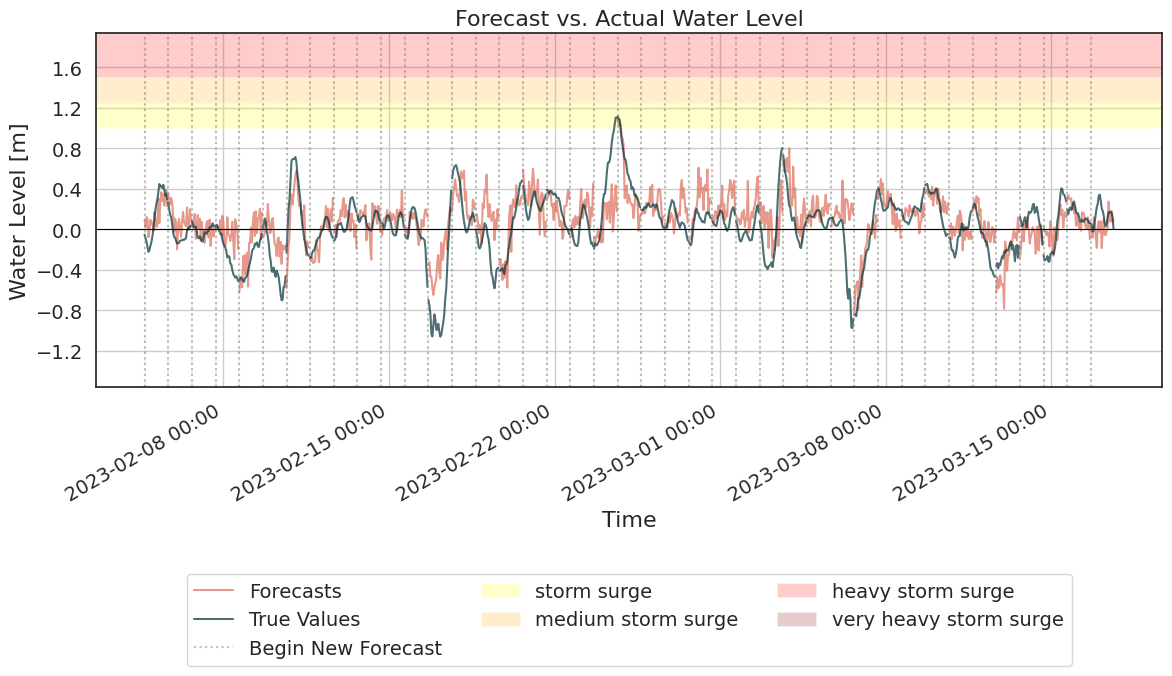

Surge2: Score = 0.2853, MSE = 0.0314, Recall = 0.6059


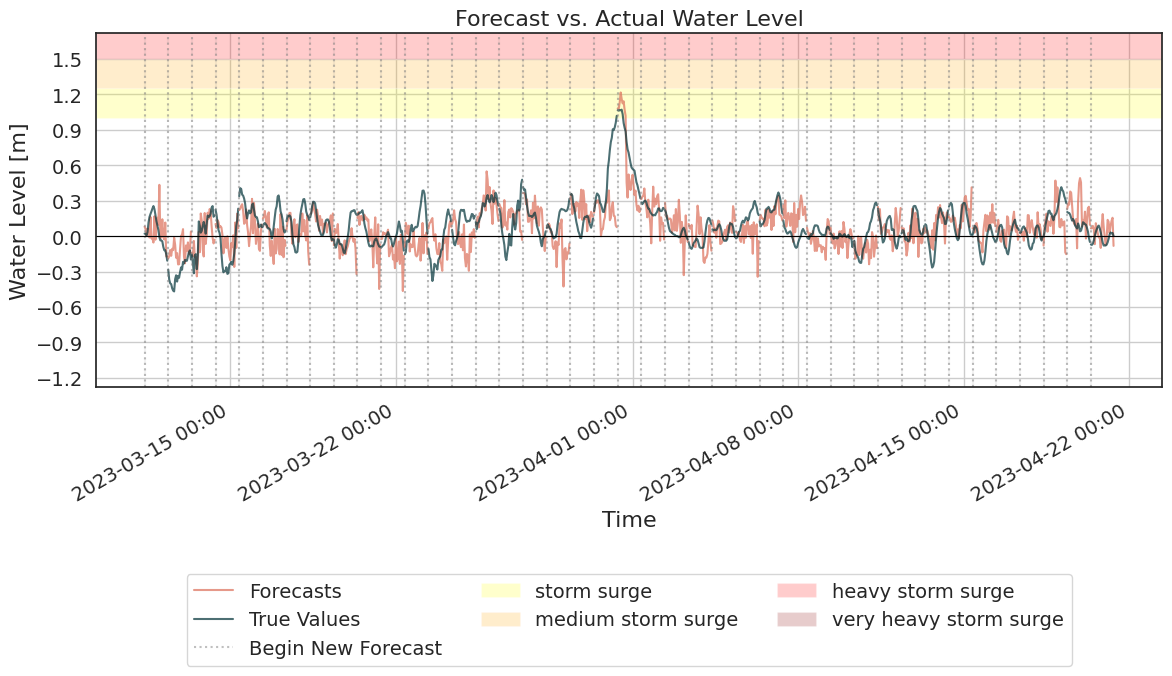

Surge3: Score = 0.5771, MSE = 0.0972, Recall = 0.2172


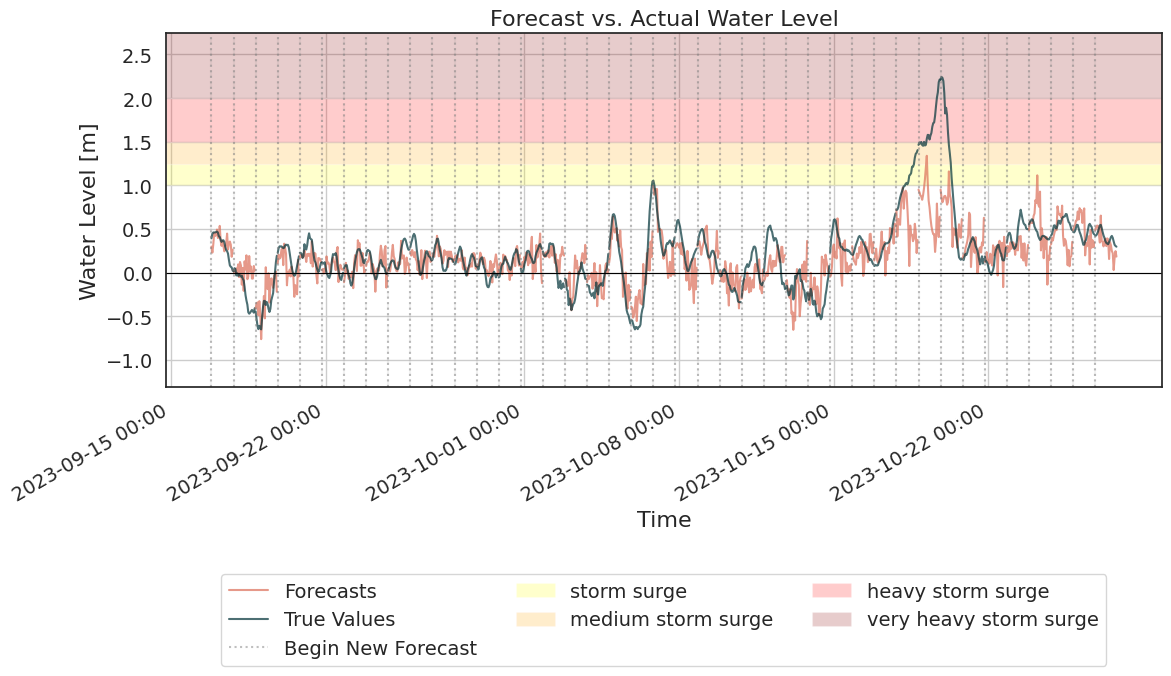

Surge4: Score = 0.5860, MSE = 0.1301, Recall = 0.2187


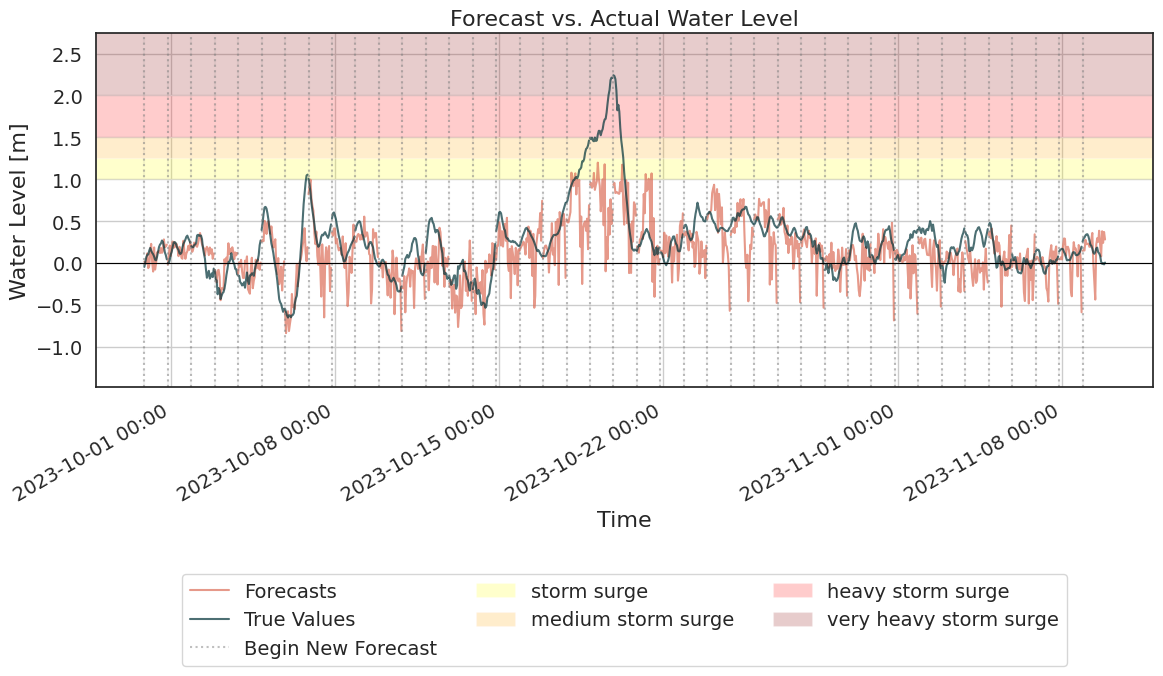

Surge5: Score = 0.3506, MSE = 0.0674, Recall = 0.5280


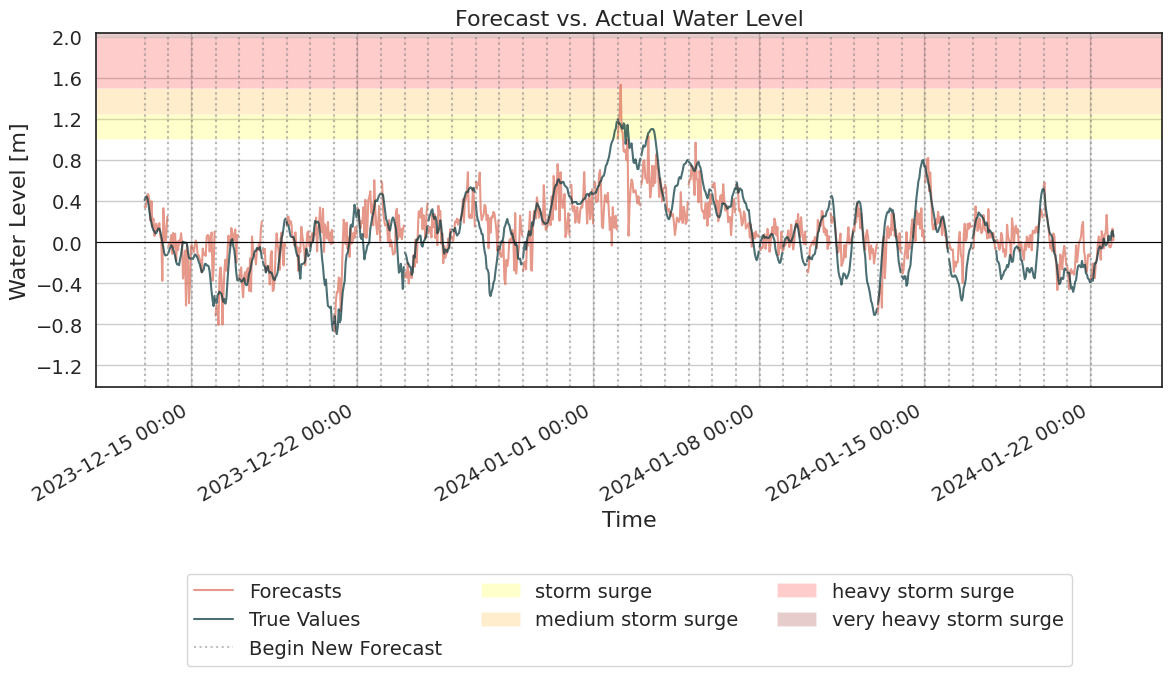

Surge6: Score = 0.4292, MSE = 0.0572, Recall = 0.4113


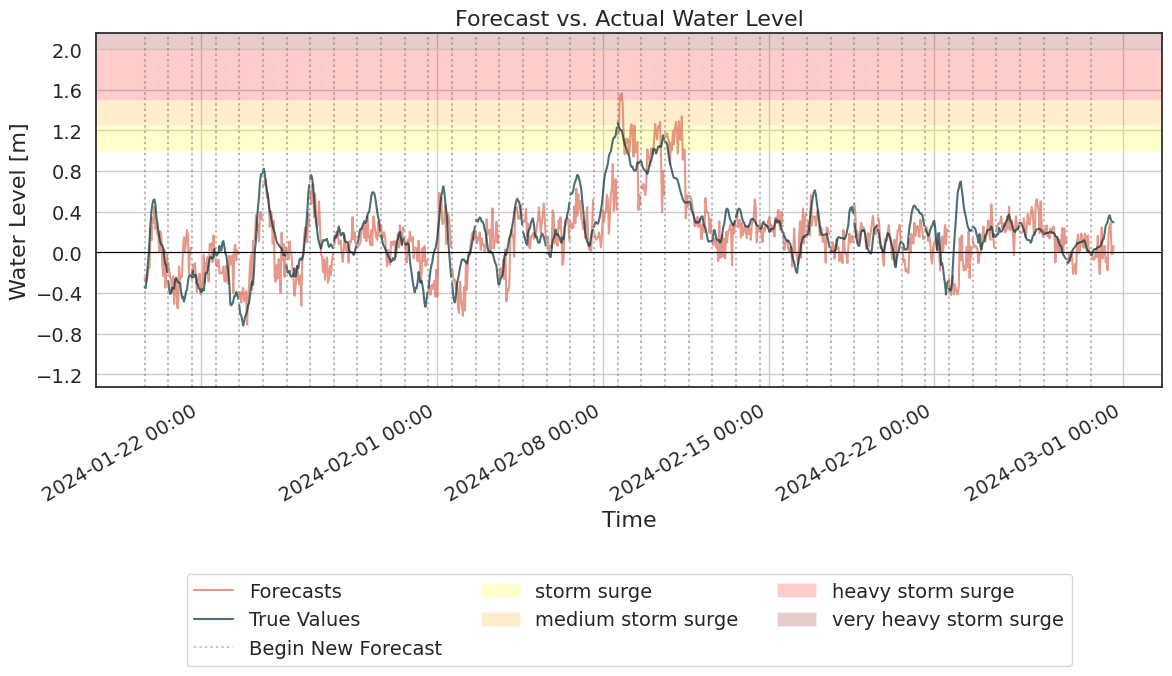

Surge7: Score = 0.3229, MSE = 0.0524, Recall = 0.5611


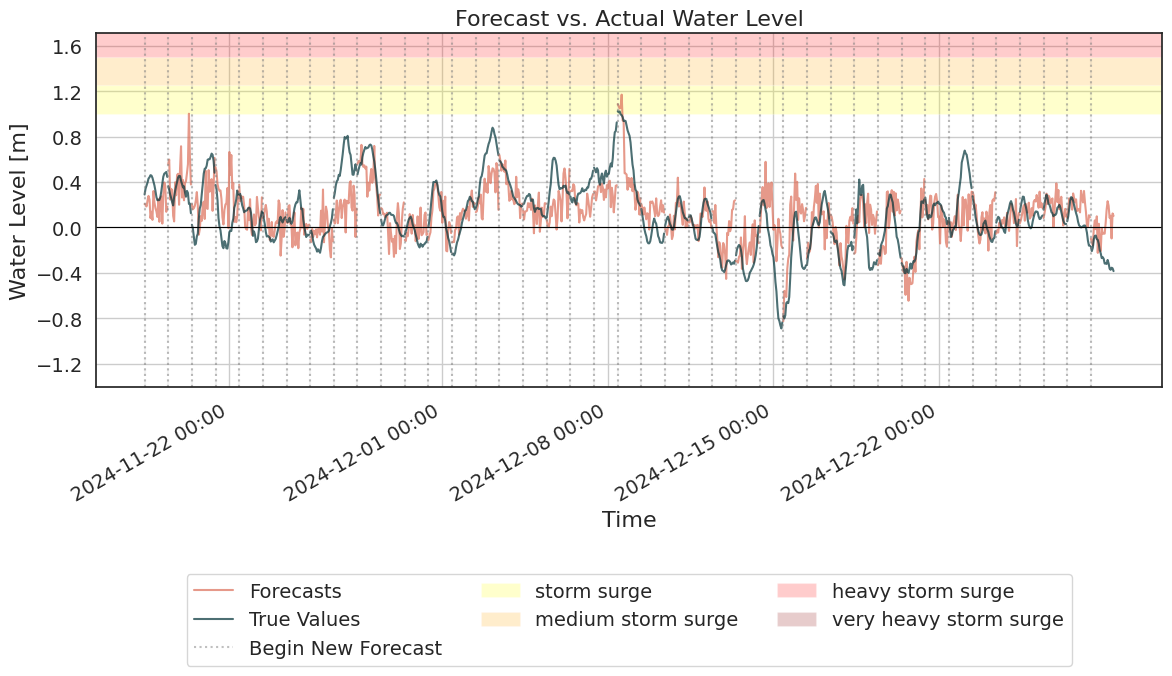

normal1: Score = 0.0071, MSE = 0.0237, Recall = 1.0000


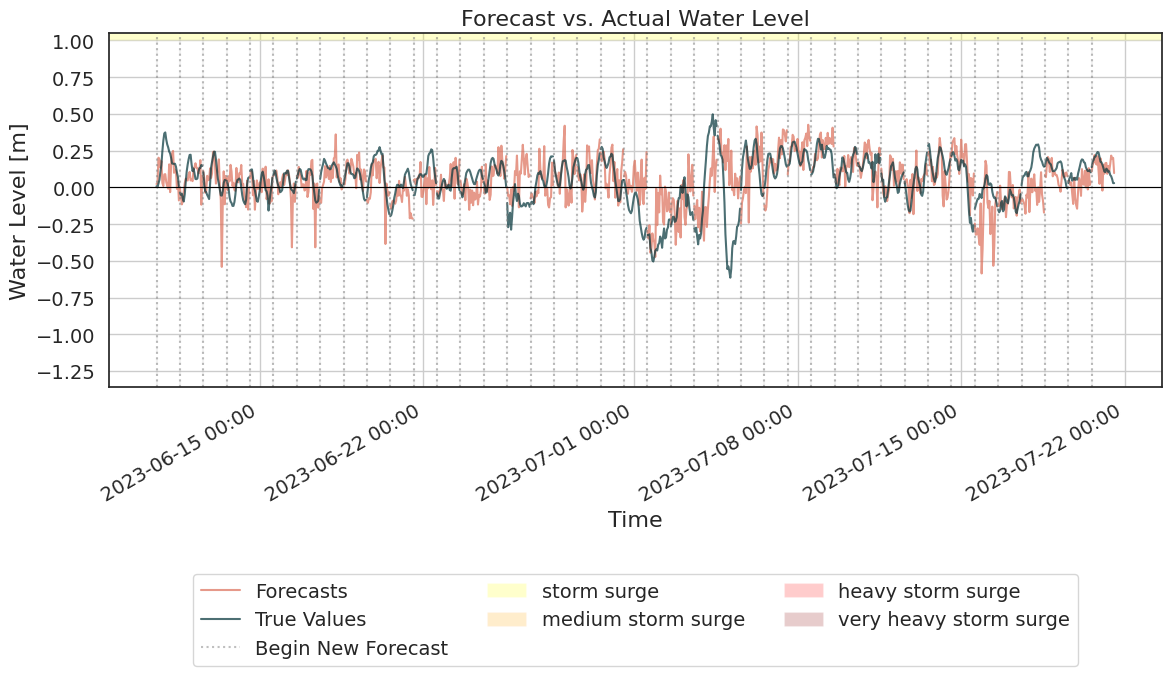

normal2: Score = 0.0089, MSE = 0.0297, Recall = 1.0000


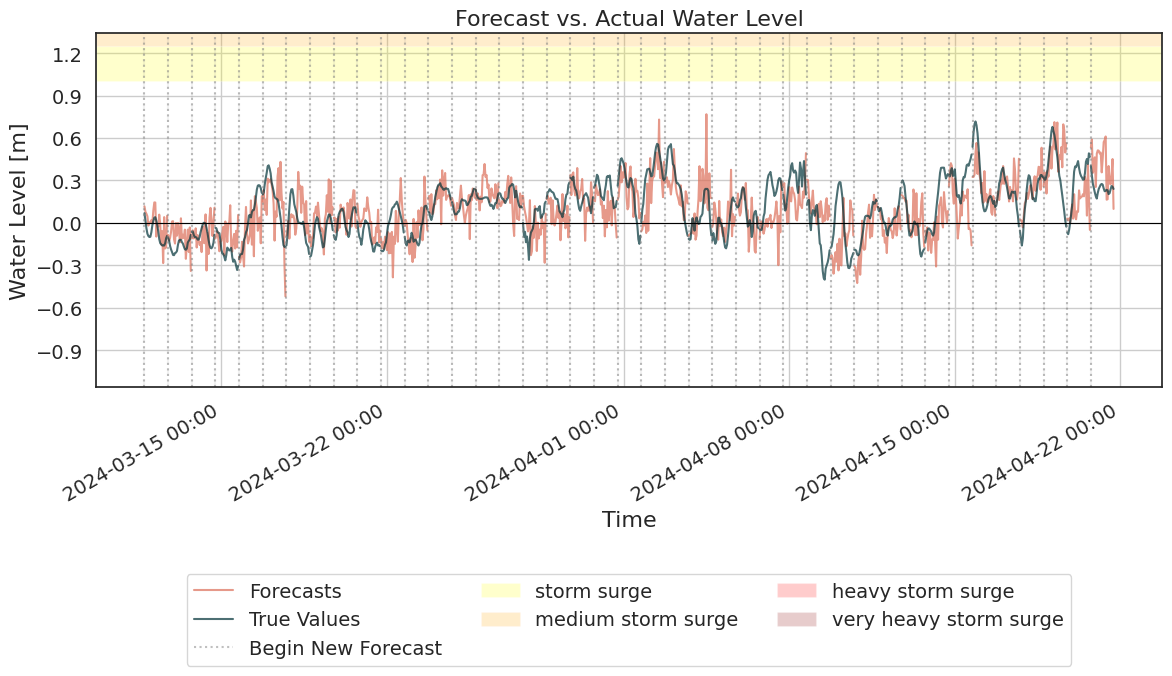

normal3: Score = 0.1112, MSE = 0.0776, Recall = 0.8743


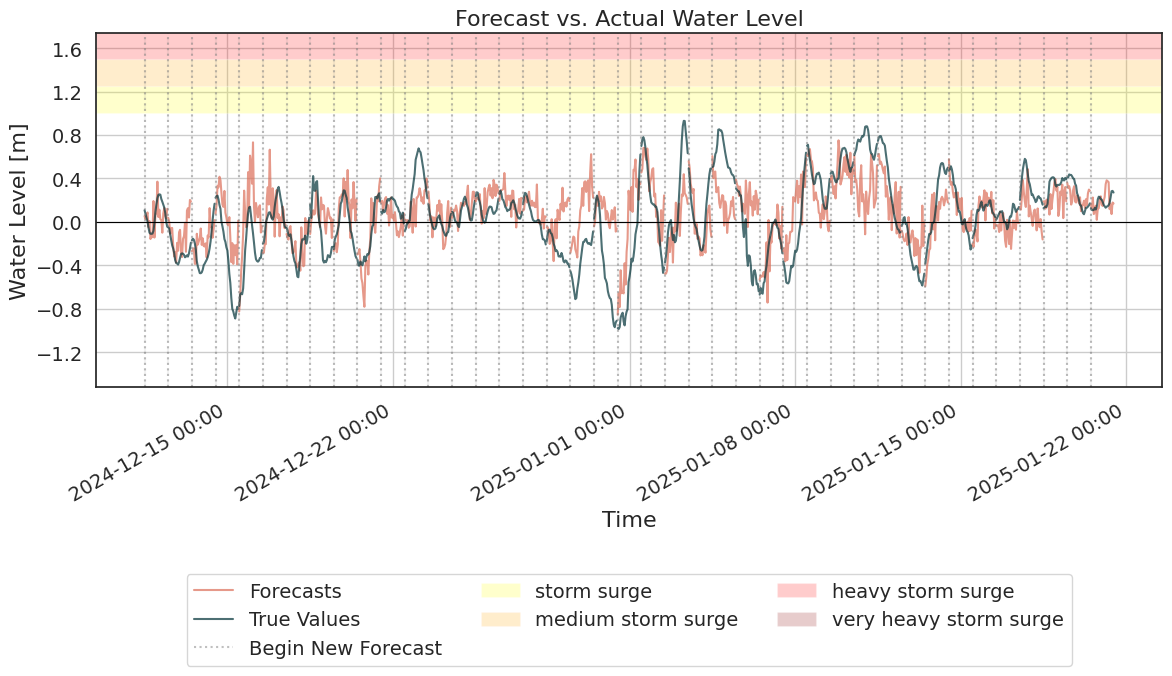


=== Cross-Validation Results ===
      fold     SCORE       MSE      RMSE    RECALL  Num Params
0   Surge1  0.331293  0.064371  0.253715  0.554312        9886
1   Surge2  0.285279  0.031411  0.177231  0.605920        9998
2   Surge3  0.577111  0.097213  0.311790  0.217218        9924
3   Surge4  0.585964  0.130139  0.360748  0.218683        9904
4   Surge5  0.350636  0.067372  0.259561  0.527966        9822
5   Surge6  0.429235  0.057222  0.239211  0.411331       10102
6   Surge7  0.322933  0.052415  0.228943  0.561130        9838
7  normal1  0.007103  0.023676  0.153870  1.000000       10302
8  normal2  0.008907  0.029690  0.172307  1.000000       10176
9  normal3  0.111246  0.077634  0.278630  0.874350        9810

Mean Score: 0.3009706403511413


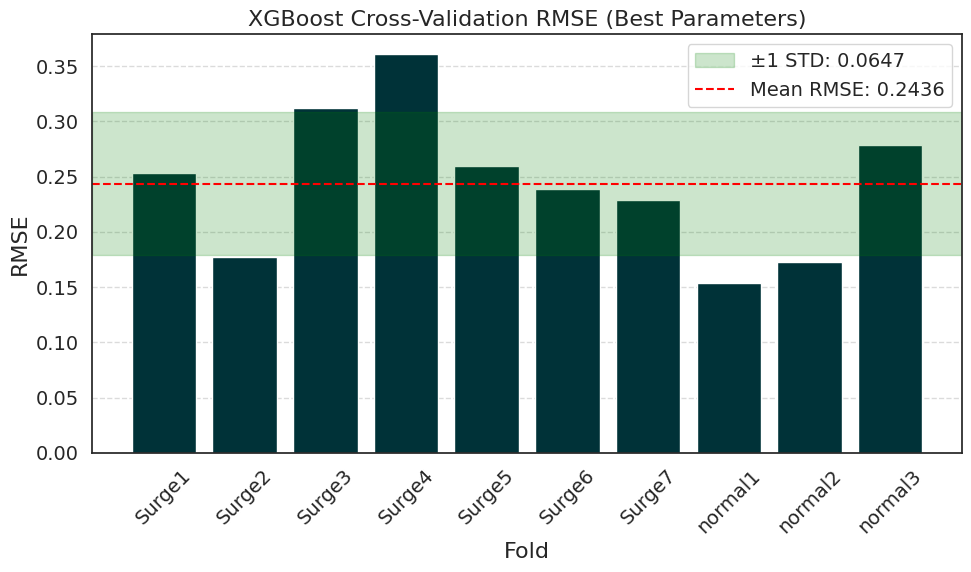

Model    MSE   RMSE    MAE  Recall  Precision  Accuracy  F1-Score  \
0  XGBoost  0.063  0.251  0.177   0.242       0.27     0.979     0.251   

   Avg. Fit Time (s)  Avg. Predict Time (s)  
0                NaN                    NaN

In [5]:
# Initialisiere Evaluator 
evaluator = MLModelEvaluator(
    X=X,
    y_lagged=y_lagged,
    y=y,
    common_time=common_time,
    sequence_length=SEQUENCE_LENGTH,
    horizon=HORIZON,
    n_jobs=n_jobs,
    dtype=DTYPE_NUMPY,
    model_name="XGBoost"  # Oder "RandomForest", "SVR", "LGBM", "Linear",
)
# Best Parameters
best_params = evaluator.get_best_params(HORIZON)

# Evaluation 
prediction_df = evaluator.evaluate_model(
    best_params=best_params,
    create_sequences=create_sequences,
    scale_data=scale_data,
)

results_df = pd.concat([results_df, get_model_statistics("XGBoost", prediction_df)], ignore_index=True)
display(results_df)

## Linear Regression

Surge1: Score = 0.2990, MSE = 0.0325, Recall = 0.5868


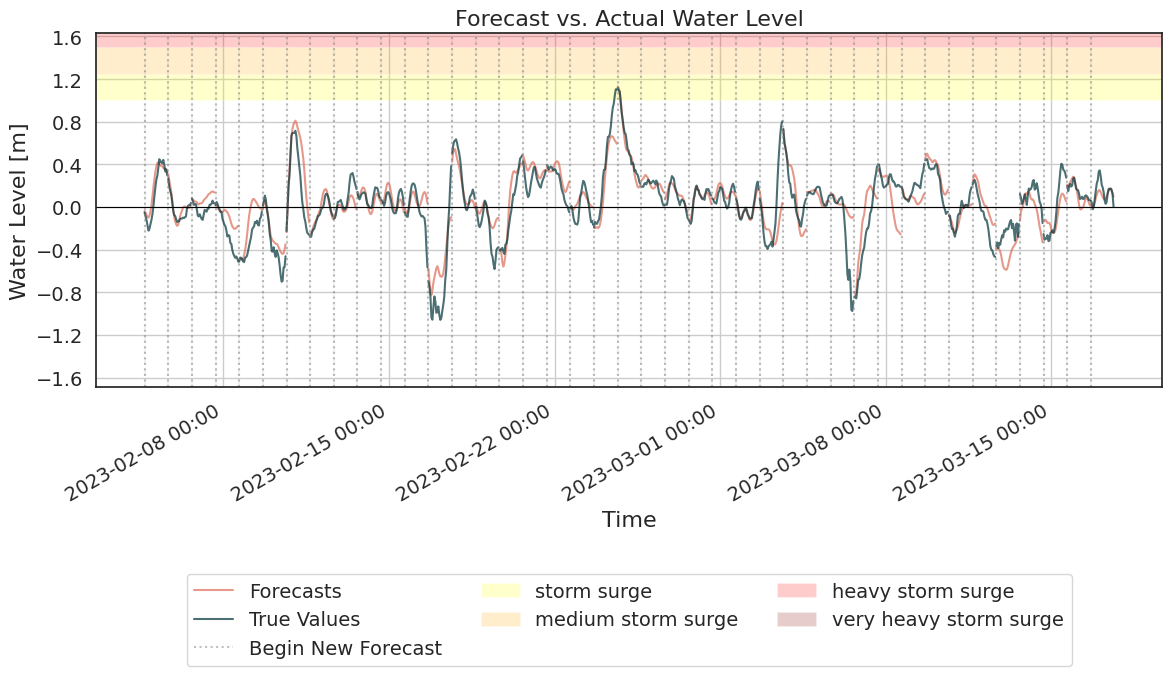

Surge2: Score = 0.3287, MSE = 0.0194, Recall = 0.5387


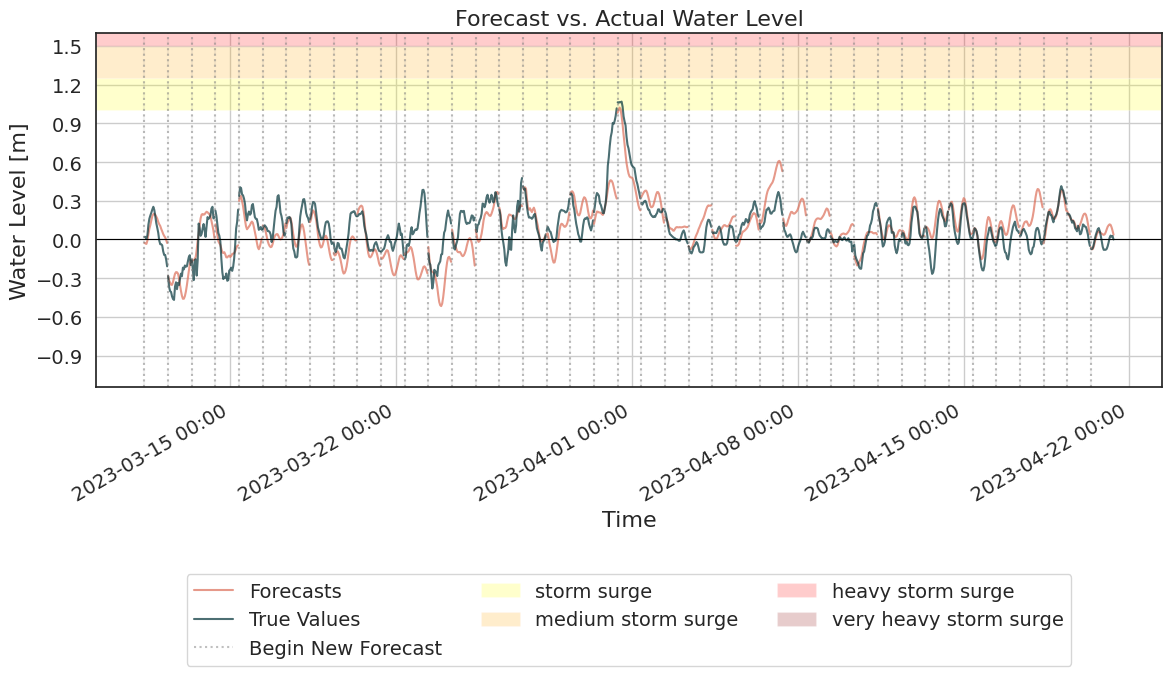

Surge3: Score = 0.4644, MSE = 0.0496, Recall = 0.3579


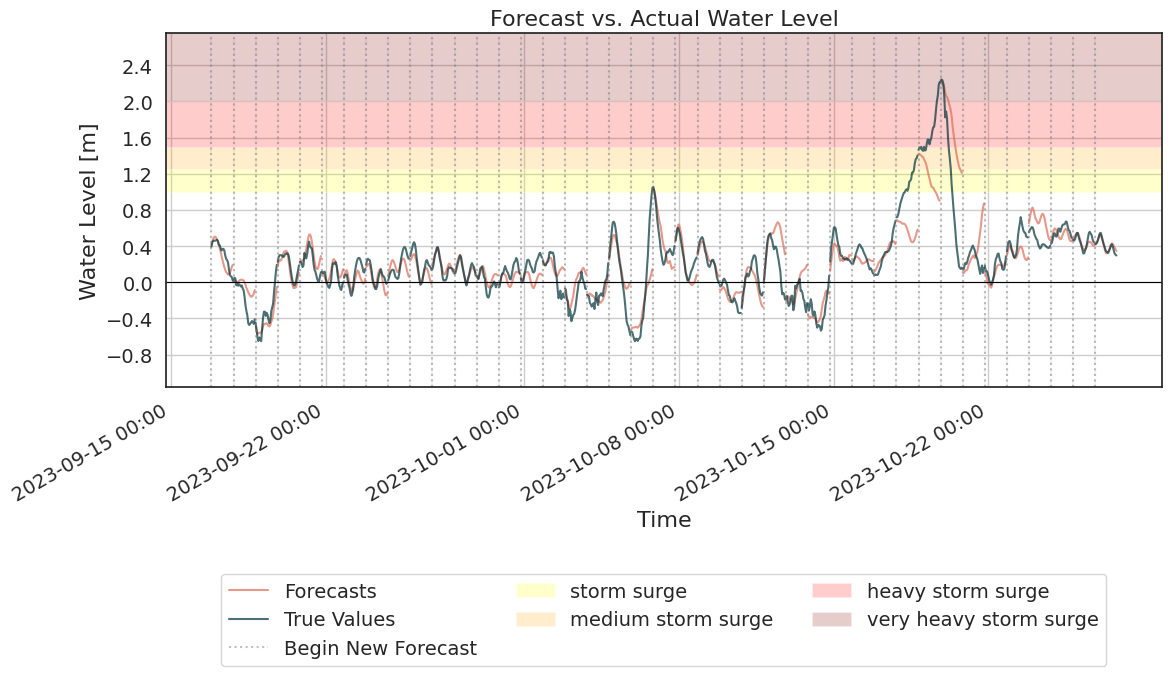

Surge4: Score = 0.4584, MSE = 0.0496, Recall = 0.3663


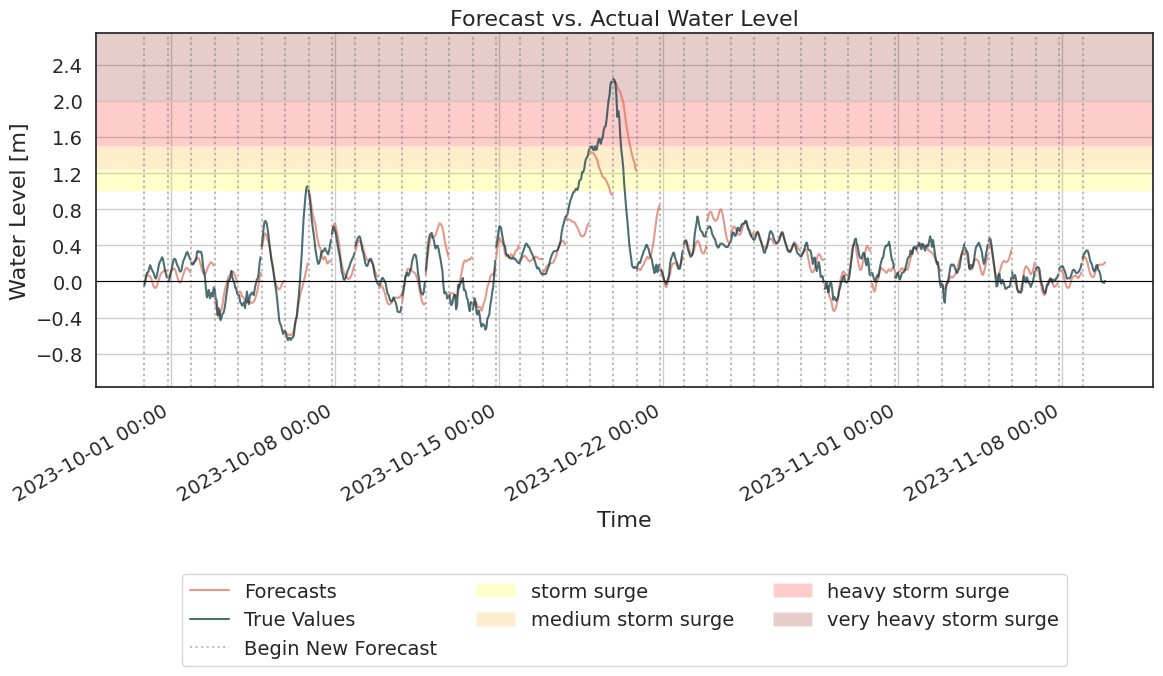

Surge5: Score = 0.3043, MSE = 0.0392, Recall = 0.5822


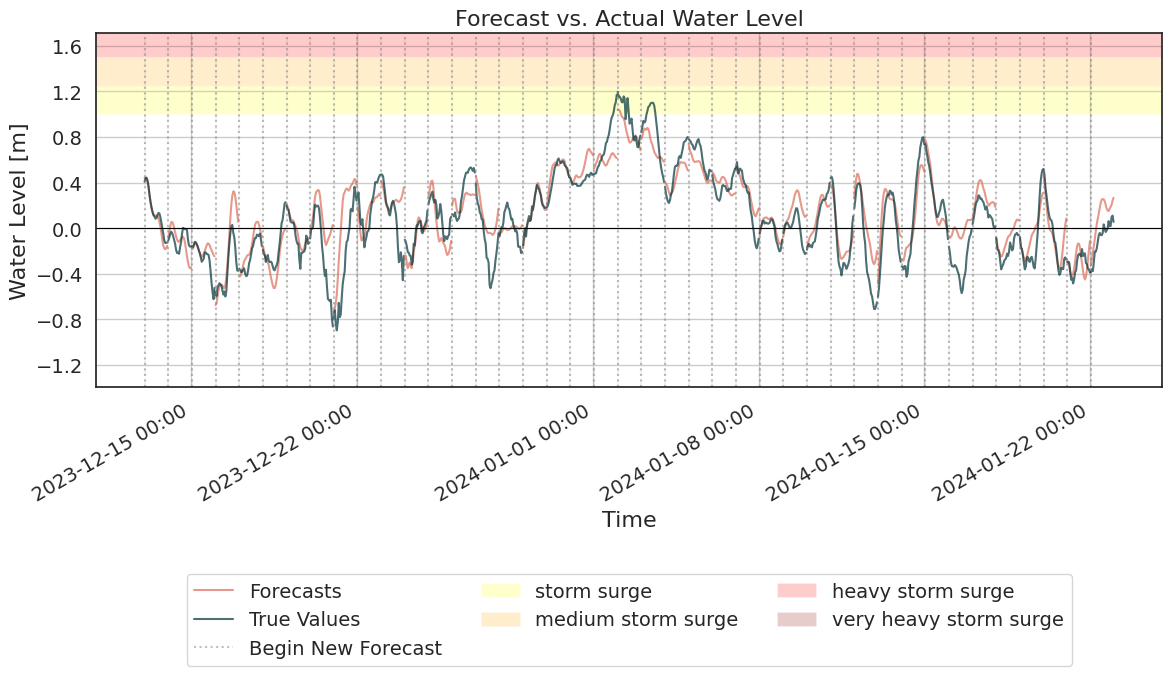

Surge6: Score = 0.4550, MSE = 0.0337, Recall = 0.3645


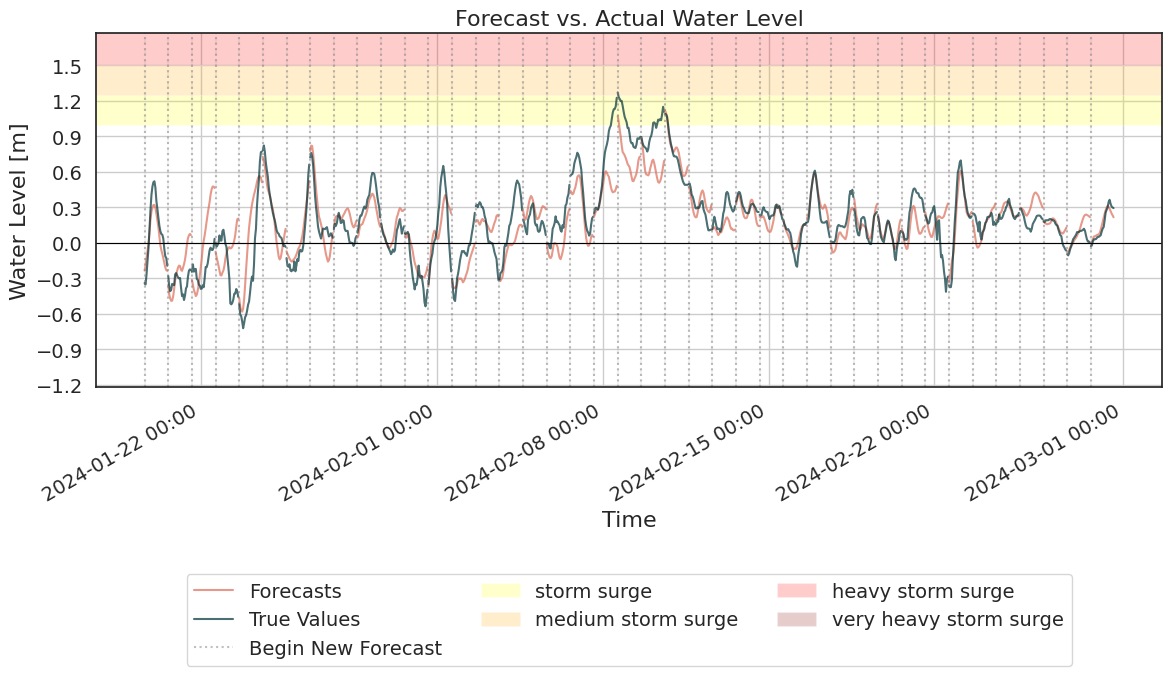

Surge7: Score = 0.3581, MSE = 0.0271, Recall = 0.5000


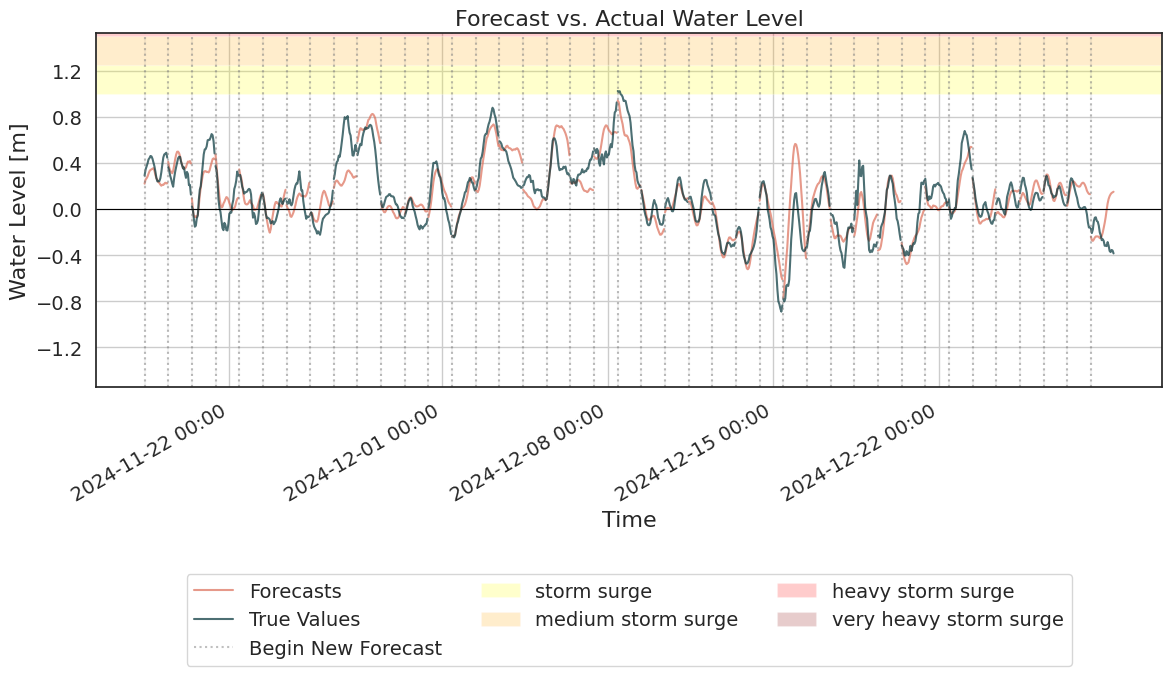

normal1: Score = 0.0055, MSE = 0.0183, Recall = 1.0000


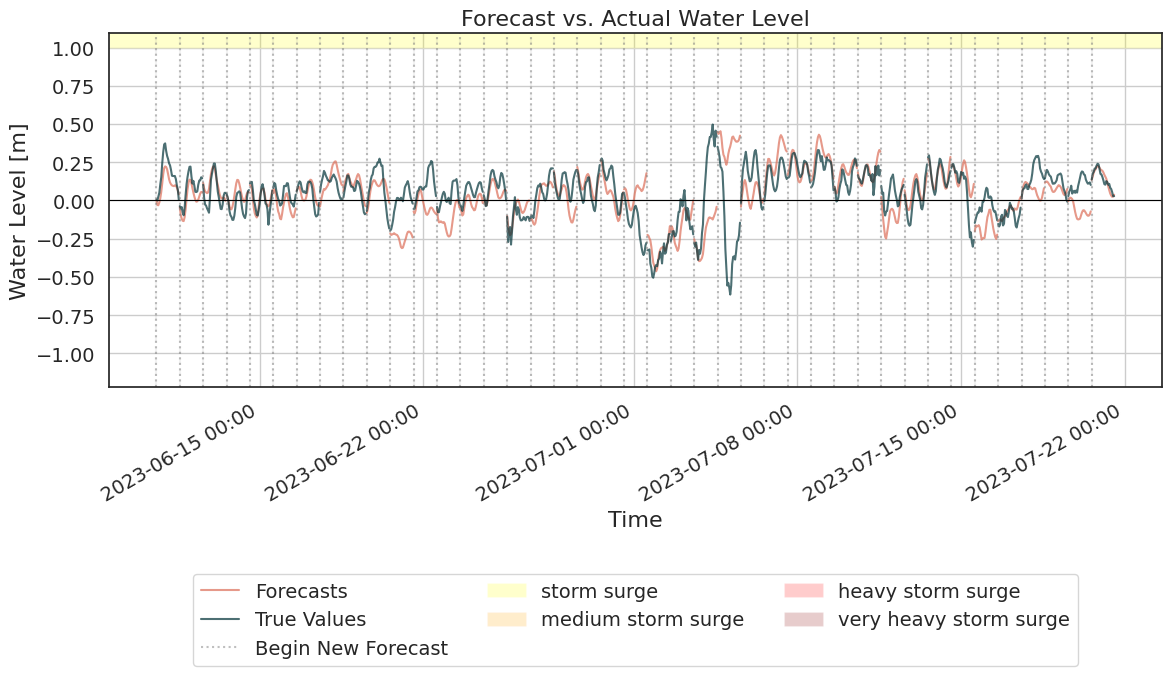

normal2: Score = 0.0059, MSE = 0.0197, Recall = 1.0000


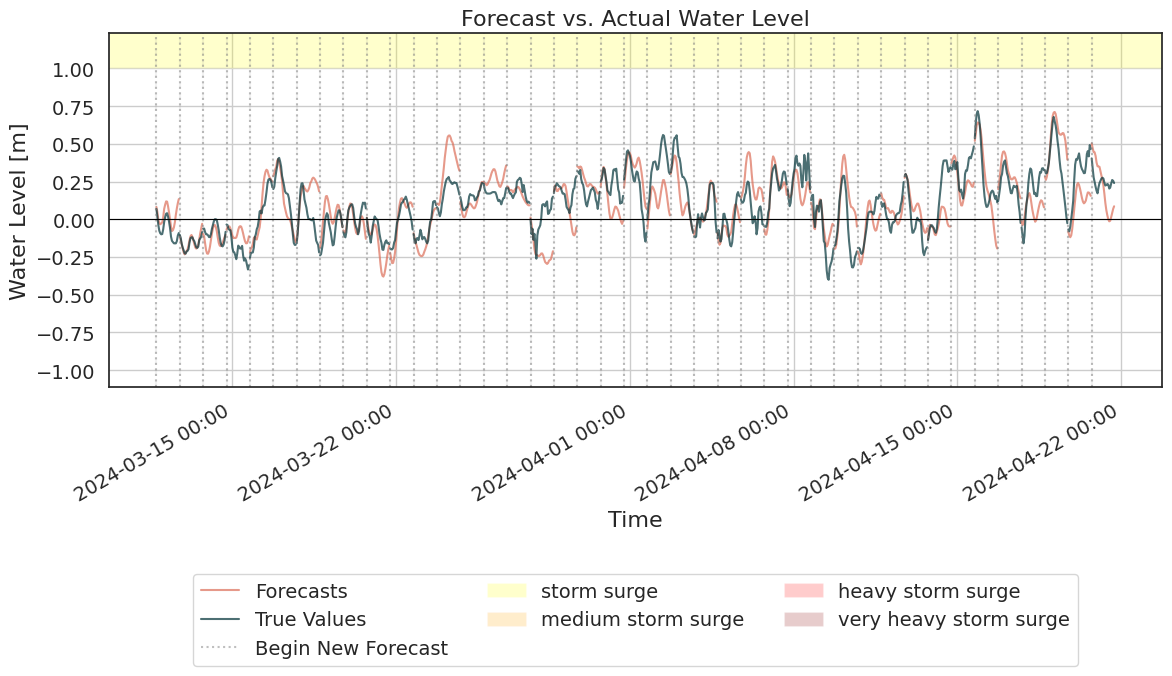

normal3: Score = 0.0164, MSE = 0.0545, Recall = 1.0000


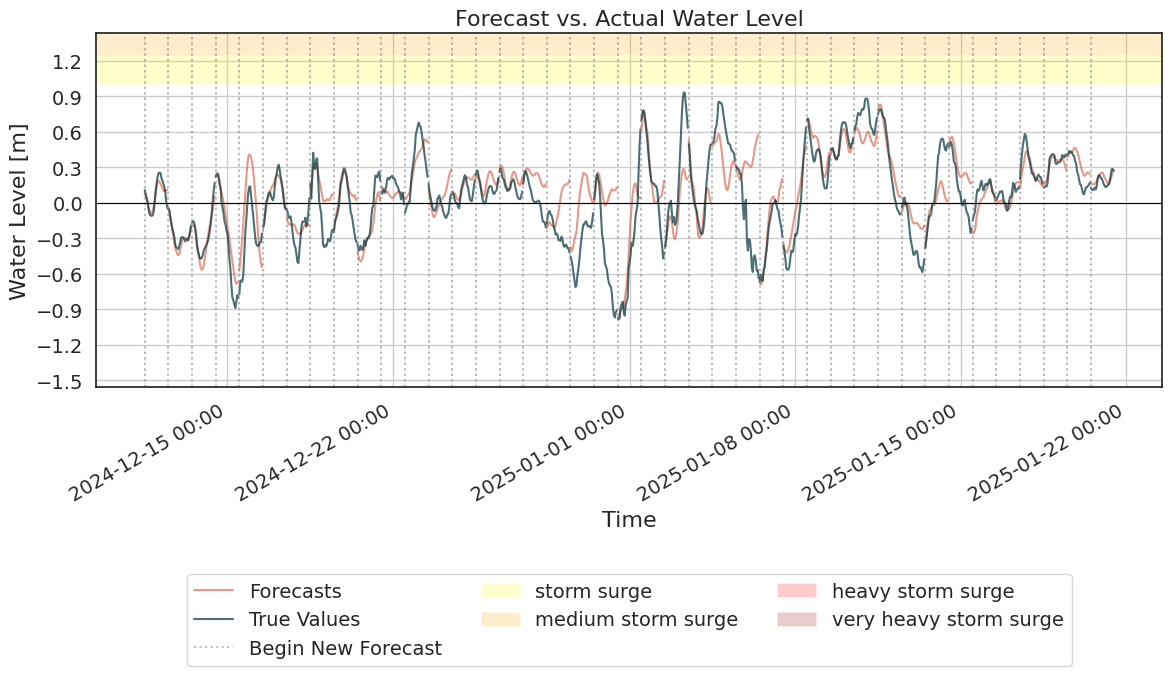


=== Cross-Validation Results ===
      fold     SCORE       MSE      RMSE    RECALL  Num Params
0   Surge1  0.299004  0.032458  0.180160  0.586762       51864
1   Surge2  0.328733  0.019388  0.139242  0.538690       51864
2   Surge3  0.464365  0.049640  0.222800  0.357895       51864
3   Surge4  0.458446  0.049601  0.222713  0.366335       51864
4   Surge5  0.304254  0.039210  0.198014  0.582155       51864
5   Surge6  0.454977  0.033726  0.183646  0.364486       51864
6   Surge7  0.358142  0.027141  0.164744  0.500000       51864
7  normal1  0.005497  0.018325  0.135369  1.000000       51864
8  normal2  0.005923  0.019744  0.140515  1.000000       51864
9  normal3  0.016357  0.054522  0.233500  1.000000       51864

Mean Score: 0.2695699695582636


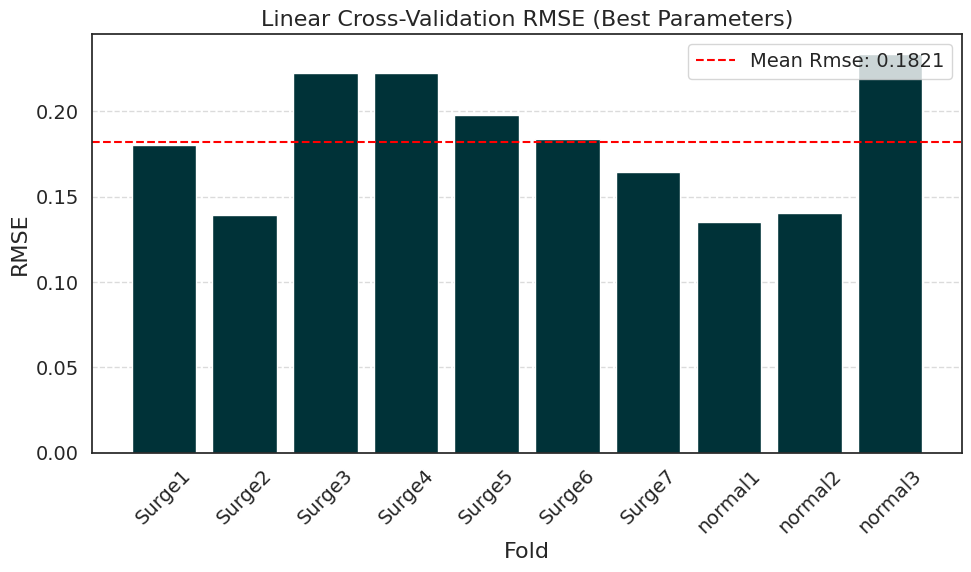

Model    MSE   RMSE    MAE  Recall  Precision  Accuracy  F1-Score  \
0  Linear  0.034  0.185  0.126   0.363      0.484     0.983     0.397   

   Avg. Fit Time (s)  Avg. Predict Time (s)  
0                NaN                    NaN

In [5]:
# Initialisiere Evaluator 
evaluator = MLModelEvaluator(
    X=X,
    y_lagged=y_lagged,
    y=y,
    common_time=common_time,
    sequence_length=SEQUENCE_LENGTH,
    horizon=HORIZON,
    n_jobs=n_jobs,
    dtype=DTYPE_NUMPY,
    model_name="Linear"  # Oder "RandomForest", "SVR", "LGBM", "Linear",
)
# Best Parameters
best_params = evaluator.get_best_params(HORIZON)

# Evaluation 
prediction_df = evaluator.evaluate_model(
    best_params=best_params,
    create_sequences=create_sequences,
    scale_data=scale_data,
)

results_df = pd.concat([results_df, get_model_statistics("Linear", prediction_df)], ignore_index=True)
display(results_df)

## Random Forest

In [ ]:
# Initialisiere Evaluator 
evaluator = MLModelEvaluator(
    X=X,
    y_lagged=y_lagged,
    y=y,
    common_time=common_time,
    sequence_length=SEQUENCE_LENGTH,
    horizon=HORIZON,
    n_jobs=n_jobs,
    dtype=DTYPE_NUMPY,
    model_name="RandomForest"  # Oder "RandomForest", "SVR", "LGBM", "Linear",
)
# Best Parameters
best_params = evaluator.get_best_params(HORIZON)

# Evaluation 
prediction_df = evaluator.evaluate_model(
    best_params=best_params,
    create_sequences=create_sequences,
    scale_data=scale_data,
)

results_df = pd.concat([results_df, get_model_statistics("RandomForest", prediction_df)], ignore_index=True)
display(results_df)

## SVR

In [ ]:
# Initialisiere Evaluator 
evaluator = MLModelEvaluator(
    X=X,
    y_lagged=y_lagged,
    y=y,
    common_time=common_time,
    sequence_length=SEQUENCE_LENGTH,
    horizon=HORIZON,
    n_jobs=n_jobs,
    dtype=DTYPE_NUMPY,
    model_name="SVR"  # Oder "RandomForest", "SVR", "LGBM", "Linear",
)
# Best Parameters
best_params = evaluator.get_best_params(HORIZON)

# Evaluation 
prediction_df = evaluator.evaluate_model(
    best_params=best_params,
    create_sequences=create_sequences,
    scale_data=scale_data,
)

results_df = pd.concat([results_df, get_model_statistics("SVR", prediction_df)], ignore_index=True)
display(results_df)

## LGBM

In [ ]:
# Initialisiere Evaluator 
evaluator = MLModelEvaluator(
    X=X,
    y_lagged=y_lagged,
    y=y,
    common_time=common_time,
    sequence_length=SEQUENCE_LENGTH,
    horizon=HORIZON,
    n_jobs=n_jobs,
    dtype=DTYPE_NUMPY,
    model_name="LGBM"  # Oder "RandomForest", "SVR", "LGBM", "Linear",
)
# Best Parameters
best_params = evaluator.get_best_params(HORIZON)

# Evaluation 
prediction_df = evaluator.evaluate_model(
    best_params=best_params,
    create_sequences=create_sequences,
    scale_data=scale_data,
)

results_df = pd.concat([results_df, get_model_statistics("LGBM", prediction_df)], ignore_index=True)
display(results_df)
model_stats_all.to_csv(results_df, "Versuch3_ML_model_statistics_all_models.csv", index=False)

## Dummydaten

In [ ]:
def generate_dummy_data():
    """
    Erzeuge Dummy-Daten mit den Shapes:
    X: (19995, 66)
    y_lagged: (19995, 56)
    y: (19995,)
    common_time: (19995,)
    """
    n_samples = 500
    X_dummy = np.random.randn(n_samples, 5).astype(DTYPE_NUMPY)
    y_lagged_dummy = np.random.randn(n_samples, 5).astype(DTYPE_NUMPY)
    y_dummy = np.random.randn(n_samples).astype(DTYPE_NUMPY)
    common_time_dummy = pd.date_range(start="2023-01-01", periods=n_samples, freq="H")
    return X_dummy, y_lagged_dummy, y_dummy, common_time_dummy

X, y_lagged, y, common_time = generate_dummy_data()


X.shape, y_lagged.shape, y.shape, common_time.shape

In [ ]:
common_time